# Lagator et al. Model

In [1]:
using wgregseq, CSV, DataFrames, CairoMakie

wgregseq.viz.default_makie!()

Precompiling wgregseq
        Info Given wgregseq was explicitly requested, output will be shown live 
  ✓ wgregseq
  1 dependency successfully precompiled in 7 seconds. 309 already precompiled.
  1 dependency had output during precompilation:
┌ wgregseq
│  [Output was shown above]
└  
┌ Warning: Font 'Lato-Regular' not found. Defaulting to NotoSans...
└ @ wgregseq.viz ~/git/Reg-Seq-2/src/viz.jl:30


Import all expression shifts.

In [2]:
df_exshifts = CSV.read("../../figures/interactive_footprints/exshifts.csv", DataFrame);

Import the model. Choosing the extended model that was fit on all their datasets. 

In [3]:
# create random sequence
numSeqs = rand([0, 1, 2, 3], 160)

# fit the model
bricks = wgregseq.promoter_finder.predict(numSeqs)

/Users/tomroeschinger/miniconda3/envs/regseq2/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 0.22.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


126×5 Matrix{Float64}:
 30.5839  20.9809  21.0324  22.6521   24.2807
 23.8918  25.5352  20.2028  23.6175   28.1
 33.6247  23.1779  29.0919  27.1227   33.4002
 29.4621  26.5433  20.3671  29.6443   30.5379
 34.0255  21.6465  22.9984  20.1853   32.3254
 31.6754  27.5864  19.478   24.193    24.2428
 36.0447  24.1562  24.3378  19.5925   27.1704
 29.4369  25.5156  17.8976  21.4424   19.5601
 28.4984  24.7068  25.0561  20.8013   27.2089
 38.8102  28.1251  28.604   32.3164   30.9245
 39.1564  30.5344  24.1199  27.9619   34.5372
 33.6957  30.1282  25.7767  22.7253   29.4303
 28.5346  21.8904  22.5934  21.6051   21.4166
  ⋮                                   
 27.4459  20.0374  23.5812  29.2801   29.5598
 35.1605  25.9671  22.8292  29.7362   38.2979
 32.5043  27.4975  22.5746  22.7999   32.5697
 28.1049  20.0334  19.2971  17.7374   20.8255
 27.3547  18.5645  14.7635  17.3904   18.6936
 39.1445  31.8063  27.2866  26.8488   32.3386
 26.8144  20.062   16.9944  15.8379   18.263
 33.307   32.9871  30.

Result should be five sequences of length 125.

In [4]:
size(bricks)

(126, 5)

Display the results of the fit.

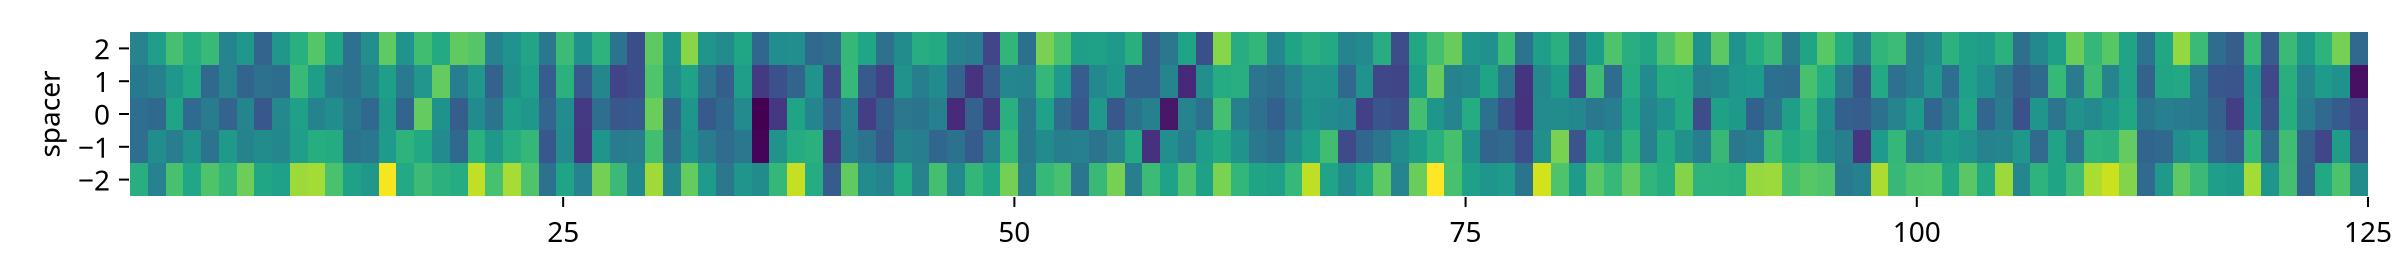

In [5]:
fig = Figure(size=(1200, 140))
ax = Axis(fig[1, 1])

heatmap!(ax, 1:125, -2:2, bricks)
ax.ylabel = "spacer"
ax.yticks = -2:2
fig

Now try with dicC promoter sequence. Try out all different possibilites for `treatas` and see if the outcome is any different.

In [16]:
df.promoter_sequence[1:30]

30-element Vector{BioSequences.LongSequence{BioSequences.DNAAlphabet{4}}}:
 TTTCATCTTTTGTCAACCATTCACAGCGCAAATATACGC…ACAAGCGATGCAAGGAATCGAACATGAAGATCGTAAAGG
 TCTGATCTTTTGTAAATCATTCACAGTGCAAATTTAAGT…ACAAGCGACGCAGGGAATCGAATATGAAGATCGTAAAGG
 TTTCATCTTTTCTCAACCACTCACAGCGTAAACTTACGC…ACAAGCGATGCATGGAATCGAACATGAAGGTCGTAAAGG
 GTTCATCCTTCTTCAACCATTCACAGCGGAAATATACGC…ACACGCGATGCAAGGAATGAAACATGAGGATCGTAAAGG
 TTTCATCTTTTGTCAACCATTCACCGCGCAAATATACGC…ACAAGCATTGCAAGGAATCGAACACGAAGATCCTTAAGG
 GTTCATCTTTTGTCAACCATTCACAGCGCGACTCTACGC…ACATGAGACGCAAGGAATCGGACATGCAGATCGTAATGG
 TTTTAGCTTTTGTCAACCATTCACAGCGCAACTATACGA…ACATGCGATGCAAGGAATCGAACTTGAATATCGTAAAAG
 TTTCATCTTTTGTCAACCAGTCATAGTGCAAATATACTG…TCAAGCGATGCAAGGAATCGAACATGAAGATCGTAAGAG
 TCTCATCTTTTGTCAACCATTAACAGCGCAAAGATCCGG…ACAAGCGATGCAAGGAATCGAACATGAAGATCGGAAAGT
 TTTCATCTTTTGTCAACCATTCACAGTGCAAATCTACGC…TCAATAGATTCAAGGAATCGAACATAAATATCGTAAAGG
 TTTCATCATTTCACAACCATTCACAGCGCAAATATACGC…ACACGCTATGCAAGGAATCGAACATGAAGATCGTAATGG
 TTTCATCTTTTGTCAACGATTAAGAGCGCCAAT

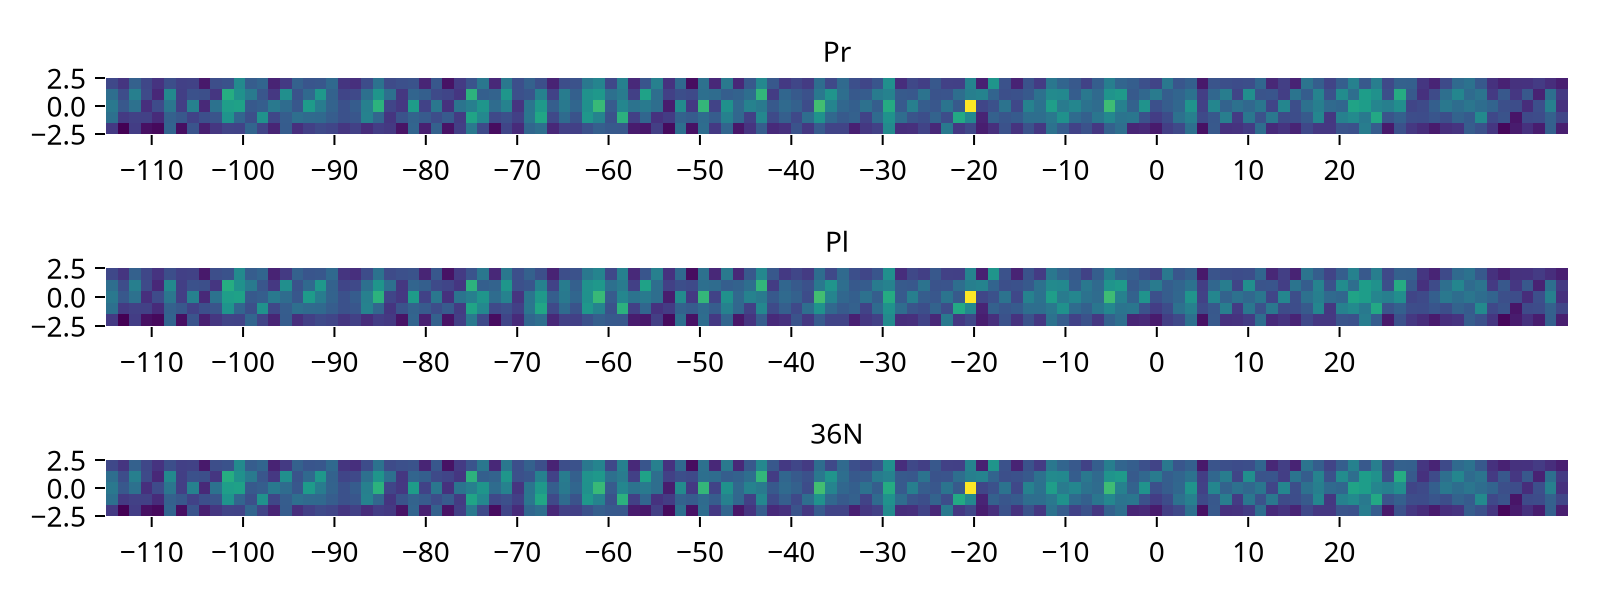

In [15]:
df = wgregseq.utils.import_twist_order("../../../data/twist_orders/2022-02-15_twist_order.csv")
insertcols!(df, 4, :promoter_sequence => map(x -> x[27:186], df.sequence))
seq = df[df.promoter .== "dicCp", "promoter_sequence"][1] |> string

num_seq_dict = Dict('A' => 0, 'C' => 1, 'G' => 2, 'T' => 3)
numseq = [num_seq_dict[x] for x in collect(seq)]

fig = Figure(size=(800, 300))
ax_list = [Axis(fig[i, 1]) for i in 1:3]
for (i, model) in enumerate(["Pr", "Pl", "36N"])
    bricks = wgregseq.promoter_finder.predict(numseq, model)
    heatmap!(ax_list[i], -115:(-115+length(numseq)), -2:2, exp.(-bricks .* .04))
    ax_list[i].title = model
    ax_list[i].xticks = -110:10:20
end

fig

Repeat the same process with the `marRp` promoter.

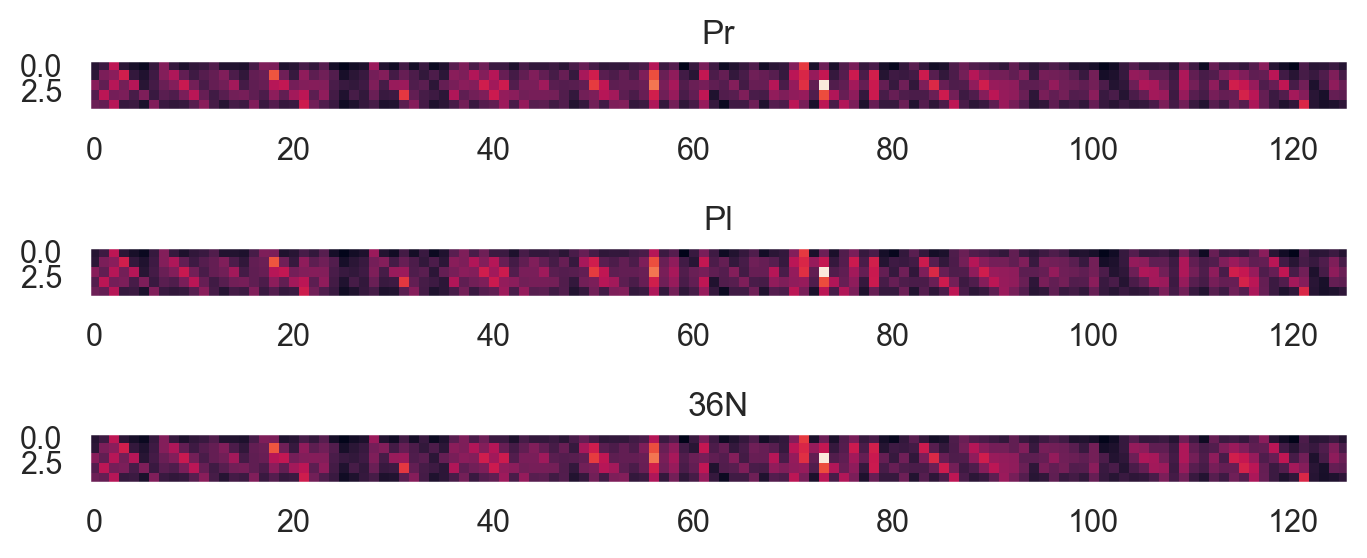

In [8]:
seq = df.loc[df.promoter == 'marRp', 'sequence'].values[0]
numseq = np.array([[num_seq_dict[x] for x in list(seq)]], dtype=np.int8)

fig, ax = plt.subplots(3,1, figsize=(7, 3))
for i, treatAs in enumerate(["Pr", "Pl", "36N"]):
    bricks = getBrickDict({treatAs: numseq}, theModel)[treatAs][0]
    ax[i].imshow(np.exp(-bricks.T*.04))
    ax[i].set_title(treatAs)
    ax[i].grid(False)

plt.tight_layout()

For both promoters, the start of the promoter is very clear and around the position we expect.

## Test model on each possible single mutation

Here we are going to compute every single point mutation in a promoter, and look for strong changes in the predicted free energy.

In [44]:
def create_mutations(sequence, add_prim=False):
    """Create all possible single base pair mutations for a given sequence
    and return them as an arry of integers."""
    
    num_seq_dict = dict(A=0, C=1, G=2, T=3)
    prim = "AGTGCCATGTTATCCCTGAATCTAGT"
    if add_prim:
        mutant_list = [[num_seq_dict[x] for x in list(prim + sequence)]]
    else:
        mutant_list = [[num_seq_dict[x] for x in list(sequence)]]
    mutations = [('N', 'N')]
    for i in range(160):
        base = sequence[i]
        for b in filter(lambda x: x != base, ['A', 'C', 'G', 'T']):
            new_sequence = list(deepcopy(sequence))
            new_sequence[i] = b
            if add_prim:
                mutant_list.append([num_seq_dict[x] for x in (list(prim) + new_sequence)])
            else:
                mutant_list.append([num_seq_dict[x] for x in list(new_sequence)])
            mutations.append((sequence[i], b))
    return np.array(mutant_list, dtype=np.int8), mutations

In [48]:
def eval_lagator_single_mutation(prom, growth_condition='Glucose', add_prim=False):
    
    # Extract sequence from dataframe
    seq = df.loc[df.promoter == prom, 'sequence'].values[0]
    # Create all single mutants
    mut_list, mutations = create_mutations(seq, add_prim)

    # Apply model to each sequence, find spacer that has maximum expression
    treatAs = "36N"
    bricks = [np.exp((-getBrickDict({treatAs: np.array([x])}, theModel)[treatAs][0])* 0.04)  for x in mut_list]
    max_bricks = [np.max(brick) for brick in bricks]
    max_bricks_inds = [np.argmax(brick) for brick in bricks]

    # Subtract the value for wild type
    max_bricks -= max_bricks[0]

    # Get mutations with maximum change in dG
    ordered_mutations = np.flip(np.argsort(max_bricks))
    print("Top 10 single mutations: ")
    df_rank = pd.DataFrame(columns=['index', 'pos', 'wt_base', 'mut_base', 'brick', 'same_TSS'])
    for i in range(len(ordered_mutations)):
        ind = ordered_mutations[i]
        df_rank.loc[i] = [ind, np.floor((ind - 1)/3)-115, *mutations[ind], max_bricks[ind], int(max_bricks_inds[ind] == max_bricks_inds[0])]
    display(df_rank.head(10))
    
    sub_df = df_exshifts.loc[(df_exshifts['growth_condition'] == growth_condition) & (df_exshifts['replicate'] == 1), :]
    sub_df.loc[:, 'pos'] = sub_df['pos']
    max_exshifts = sub_df.groupby('promoter').apply(lambda x: np.flip(np.argsort(np.abs(x['expression_shift'].values))), include_groups=False)
    
    prom_df = df_exshifts.loc[(df_exshifts['growth_condition'] == growth_condition) & (df_exshifts['replicate'] == 1) & (df_exshifts['promoter'] == prom), :].reset_index(drop=True)
    int_to_base = {1:'A', 2:'C', 3:'G', 4:'T'}
    prom_df.rename(columns={'base': 'int_base'}, inplace=True)
    prom_df.loc[:, 'base'] = [int_to_base[x] for x in prom_df['int_base']]
    
    print("Highest observed expression shift: ")
    display(prom_df.iloc[max_exshifts[prom][0]])

    pos = prom_df.iloc[max_exshifts[prom][0]]['pos']
    wt_base = prom_df.iloc[max_exshifts[prom][0]]['wt_base']
    mut_base = prom_df.iloc[max_exshifts[prom][0]]['base']

    predict_dG = df_rank.loc[(df_rank['pos'] == pos) & (df_rank['wt_base'] == wt_base) &(df_rank['mut_base'] == mut_base), 'brick'].values[0]
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.plot(np.sort(max_bricks), np.arange(len(max_bricks))/len(max_bricks))
    ax.vlines(predict_dG, ymin=0, ymax=1, color="orange", linestyle="--", label='Highest Expression Shift')
    ax.legend()
    ax.set_xlabel("predicted dG relative to WT")
    ax.set_ylabel("ECDF")
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    return df_rank




In [64]:
def get_reads(promoter):
    df_reads_DNA = pd.read_csv("../../../data/barcode_counts/20230907_barcode/1-1_DNA_collapsed.txt", sep='\s+', names=['ct_0', 'barcode'])
    df_reads_RNA = pd.read_csv("../../../data/barcode_counts/20230907_barcode/1-1_RNA_collapsed.txt", sep="\s+", names=['ct_1', 'barcode'])
    df_map = pd.read_csv("../../../data/barcode_maps/20220514_mapping/mapped_barcodes_filtered.csv")
    
    df_counts = pd.merge(df_reads_DNA, df_reads_RNA, on='barcode', how='outer')
    df_reads = pd.merge(df_counts, df_map, on='barcode', how="inner")
    return df_reads.loc[df_reads['name'] == promoter, :].fillna(0).reset_index(drop=True)

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/var/folders/67/2rd1gct91876bvjs_7ny9rcw0000gn/T/ipykernel_33004/535626821.py:2: SyntaxWarning: invalid escape sequence '\s'
  df_reads_DNA = pd.read_csv("../../../data/barcode_counts/20230907_barcode/1-1_DNA_collapsed.txt", sep='\s+', names=['ct_0', 'barcode'])
/var/folders/67/2rd1gct91876bvjs_7ny9rcw0000gn/T/ipykernel_33004/535626821.py:3: SyntaxWarning: invalid escape sequence '\s'
  df_reads_RNA = pd.read_csv("../../../data/barcode_counts/20230907_barcode/1-1_RNA_collapsed.txt", sep="\s+", names=['ct_1', 'barcode'])


In [65]:
get_reads('mglBp')

,ct_0,barcode,ct_1,promoter,counts,name
0,1.0,AAAAAAAACTTTTAAATTCC,2.0,CAACACGCCAGAATGTGGCGGGAATCAGTAACTCCACAAATCTGGC...,72,mglBp
1,0.0,AAAAAAAGGTTTAACACCCA,4.0,CAACACGCCAGAATGCTCCGGCCATCACTAACGTAGCAAGTCAGGC...,85,mglBp
2,1.0,AAAAACAATAAGAAGGAAAG,1.0,GTACACGCCAGAATGGCGCGGCGATGACTAACTCAACAAATCAGGC...,543,mglBp
3,1.0,AAAAACTAACATGGGTCCAC,18.0,CAACACGCCAGAATGCGGCGGAGATCACTAACTTAACAAATCAGCC...,15,mglBp
4,1.0,AAAAAGACGTTGGTGTCCTA,0.0,CAACACGCCAGAATGCGGCGGCGTTCATTAAATCAACGAATCAGGC...,68,mglBp
...,...,...,...,...,...,...
18521,1.0,TTTTTTGGCGGAAATGGCGT,0.0,CAACACGCCAGAATGCGGCGGCGATCAATAACTCAACCAATCAGGA...,100,mglBp
18522,1.0,TTTTTTTAACCTTGATGGGA,0.0,CCACACGCCTGAATGCGGCGGCGATCACTAAGTCAACAAATCAGGC...,43,mglBp
18523,1.0,TTTTTTTCTCCCCTTTCAGG,2.0,CAACACGGCAGGATGCAGCGGCGGTCACTAACTCAACTAATCAGGC...,7,mglBp
18524,0.0,TTTTTTTGACACGTTACTCC,1.0,CAACACGCCAGAATGCGGCGTCGATCCCTAACTTAACAAATCACGC...,30,mglBp


### mglBp

Top 10 single mutations: 


,index,pos,wt_base,mut_base,brick,same_TSS
0,438,30.0,A,T,0.169513,1
1,417,23.0,A,T,0.128428,0
2,266,-27.0,A,G,0.119134,0
3,283,-21.0,G,A,0.100824,0
4,285,-21.0,G,T,0.092693,0
5,379,11.0,T,A,0.078502,1
6,233,-38.0,C,G,0.067193,0
7,333,-5.0,C,T,0.059210,0
8,312,-12.0,A,T,0.058062,0
9,382,12.0,A,C,0.056242,1


Highest observed expression shift: 


promoter                                              mglBp
source                                               genome
expression_shift                                        1.0
growth_condition                                    Glucose
growth_condition_info    M9 Minimal Media with 0.5% Glucose
replicate                                                 1
pos                                                      30
int_base                                                  4
wt_base                                                   A
base                                                      T
Name: 583, dtype: object

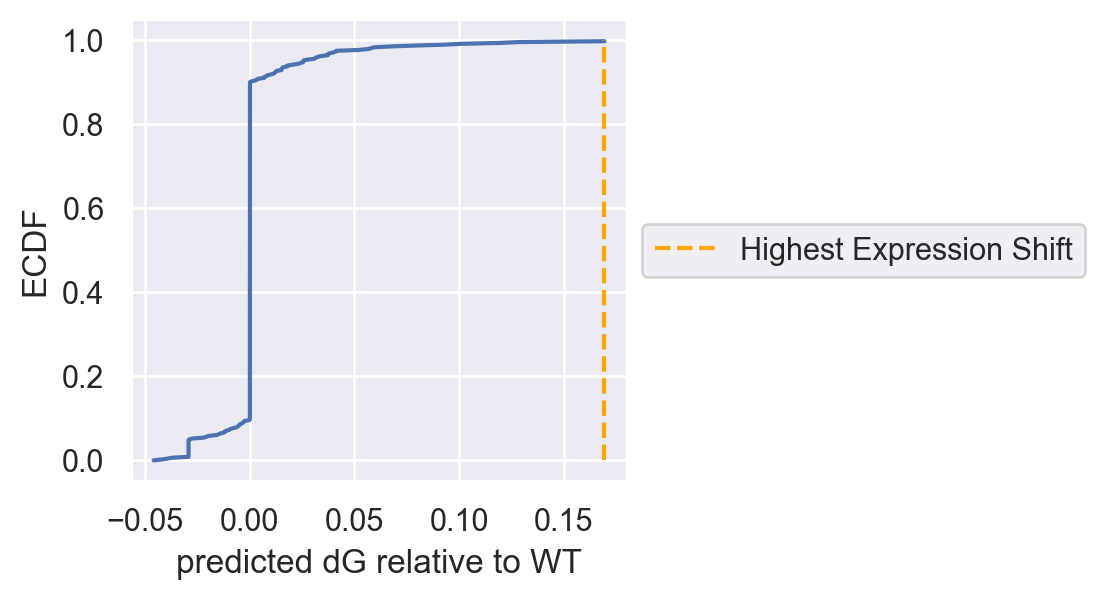

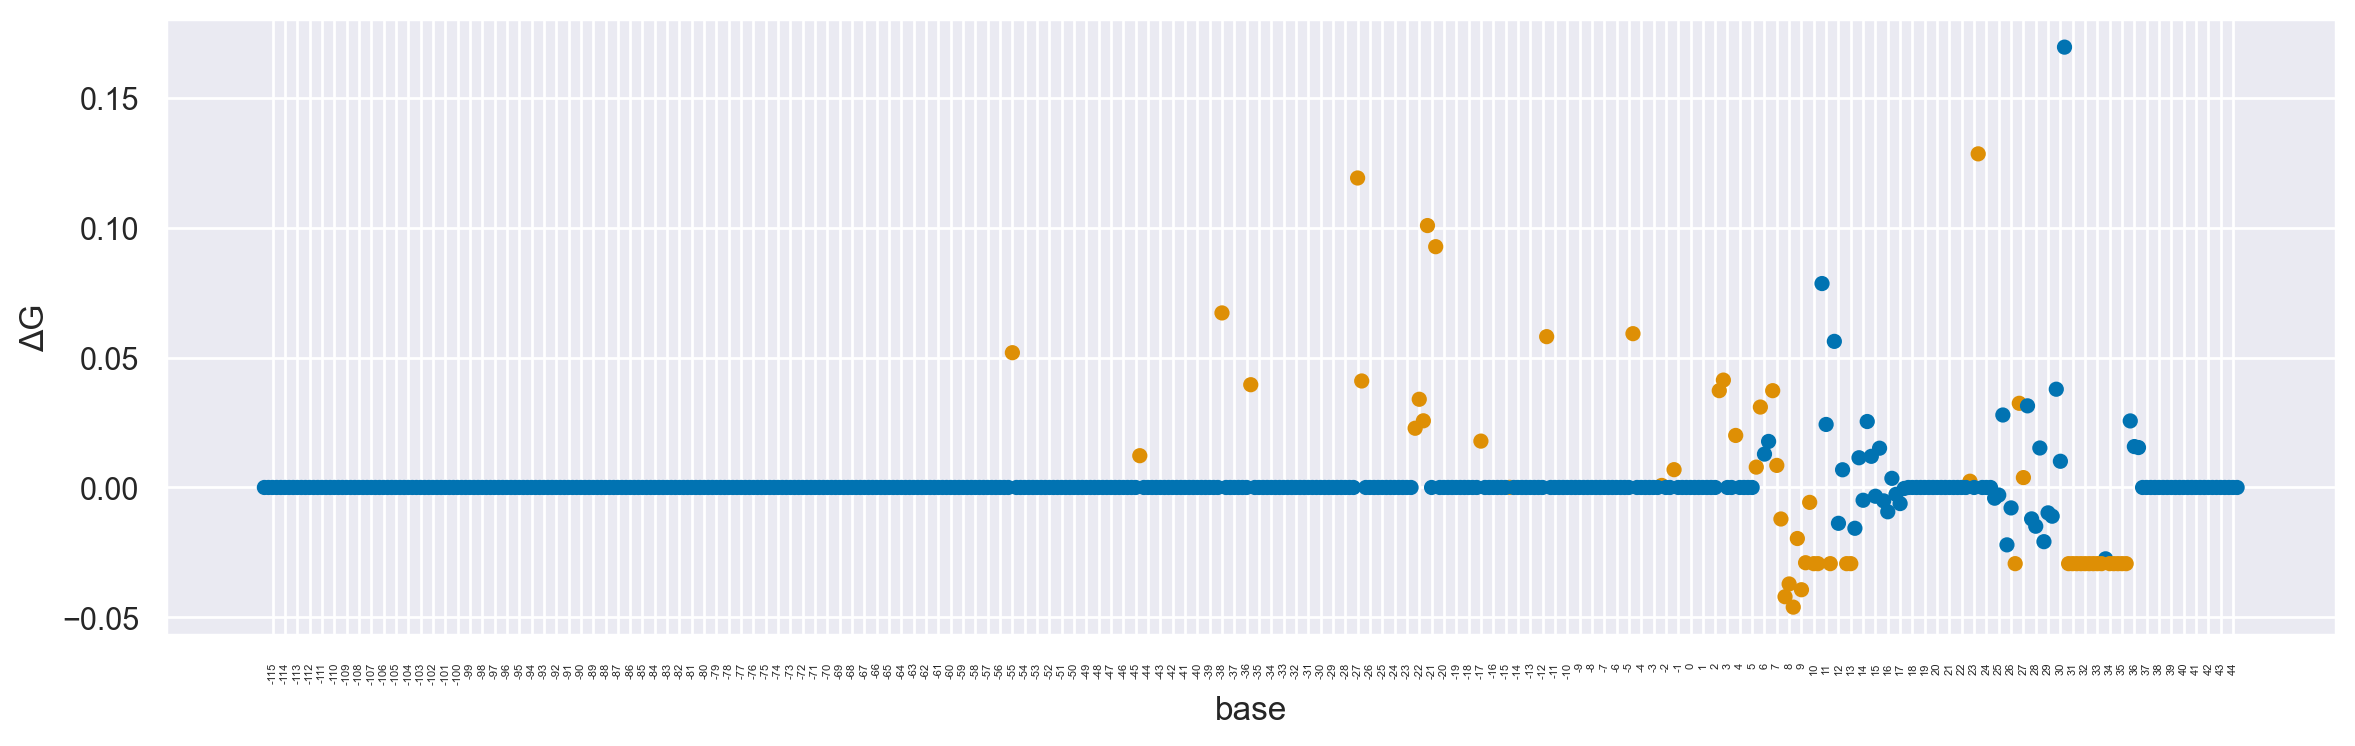

In [52]:
x = eval_lagator_single_mutation('mglBp', 'Glucose')

color_dict = {
    1: sns.color_palette('colorblind')[0],
    0: sns.color_palette('colorblind')[1]
}

fig, ax = plt.subplots(figsize=(14, 4))
ax.scatter(x['index'], x['brick'], color=[color_dict[y] for y in x['same_TSS']], s=20)#, color=x['same_TSS'])
ax.set_ylabel("ΔG")
ax.set_xlabel("base")
ax.set_xticks(np.arange(2, 480, 3), [str(x - 116) for x in np.arange(1, 161)], fontsize=4, rotation=90);

### ldrDp

Top 10 single mutations: 


,index,pos,wt_base,mut_base,brick,same_TSS
0,237,-37.0,G,T,0.140238,1
1,244,-34.0,C,A,0.058219,1
2,248,-33.0,T,C,0.054217,1
3,312,-12.0,G,T,0.053894,1
4,250,-32.0,G,A,0.042087,1
5,291,-19.0,A,T,0.035623,1
6,299,-16.0,C,G,0.033970,1
7,322,-8.0,C,A,0.028348,1
8,252,-32.0,G,T,0.023862,1
9,323,-8.0,C,G,0.017427,1


Highest observed expression shift: 


promoter                                              ldrDp
source                                               genome
expression_shift                                        1.0
growth_condition                                    Glucose
growth_condition_info    M9 Minimal Media with 0.5% Glucose
replicate                                                 1
pos                                                     -96
int_base                                                  4
wt_base                                                   A
base                                                      T
Name: 79, dtype: object

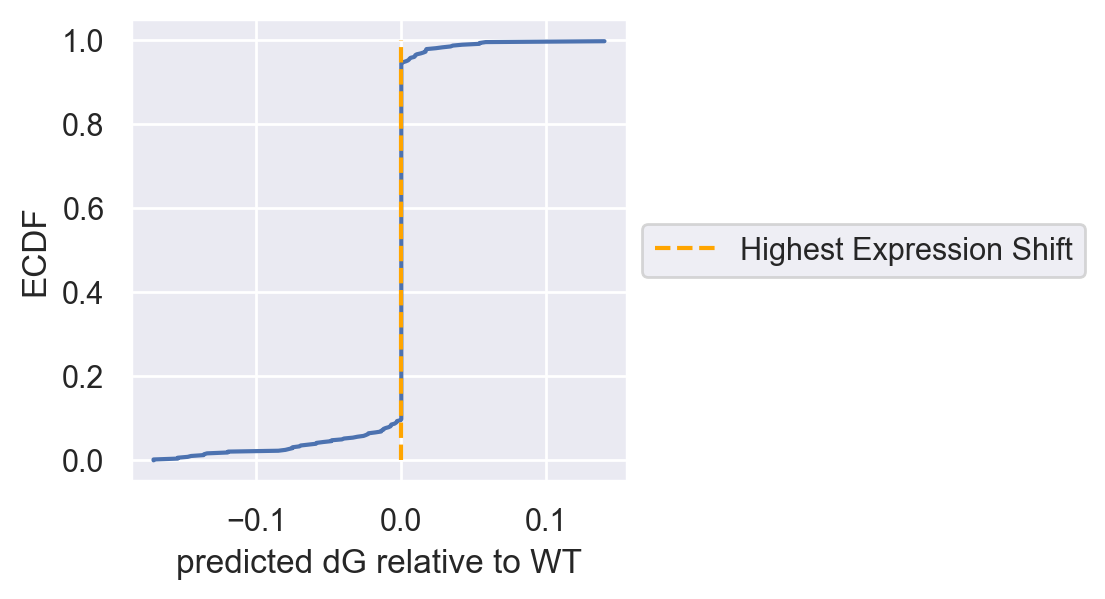

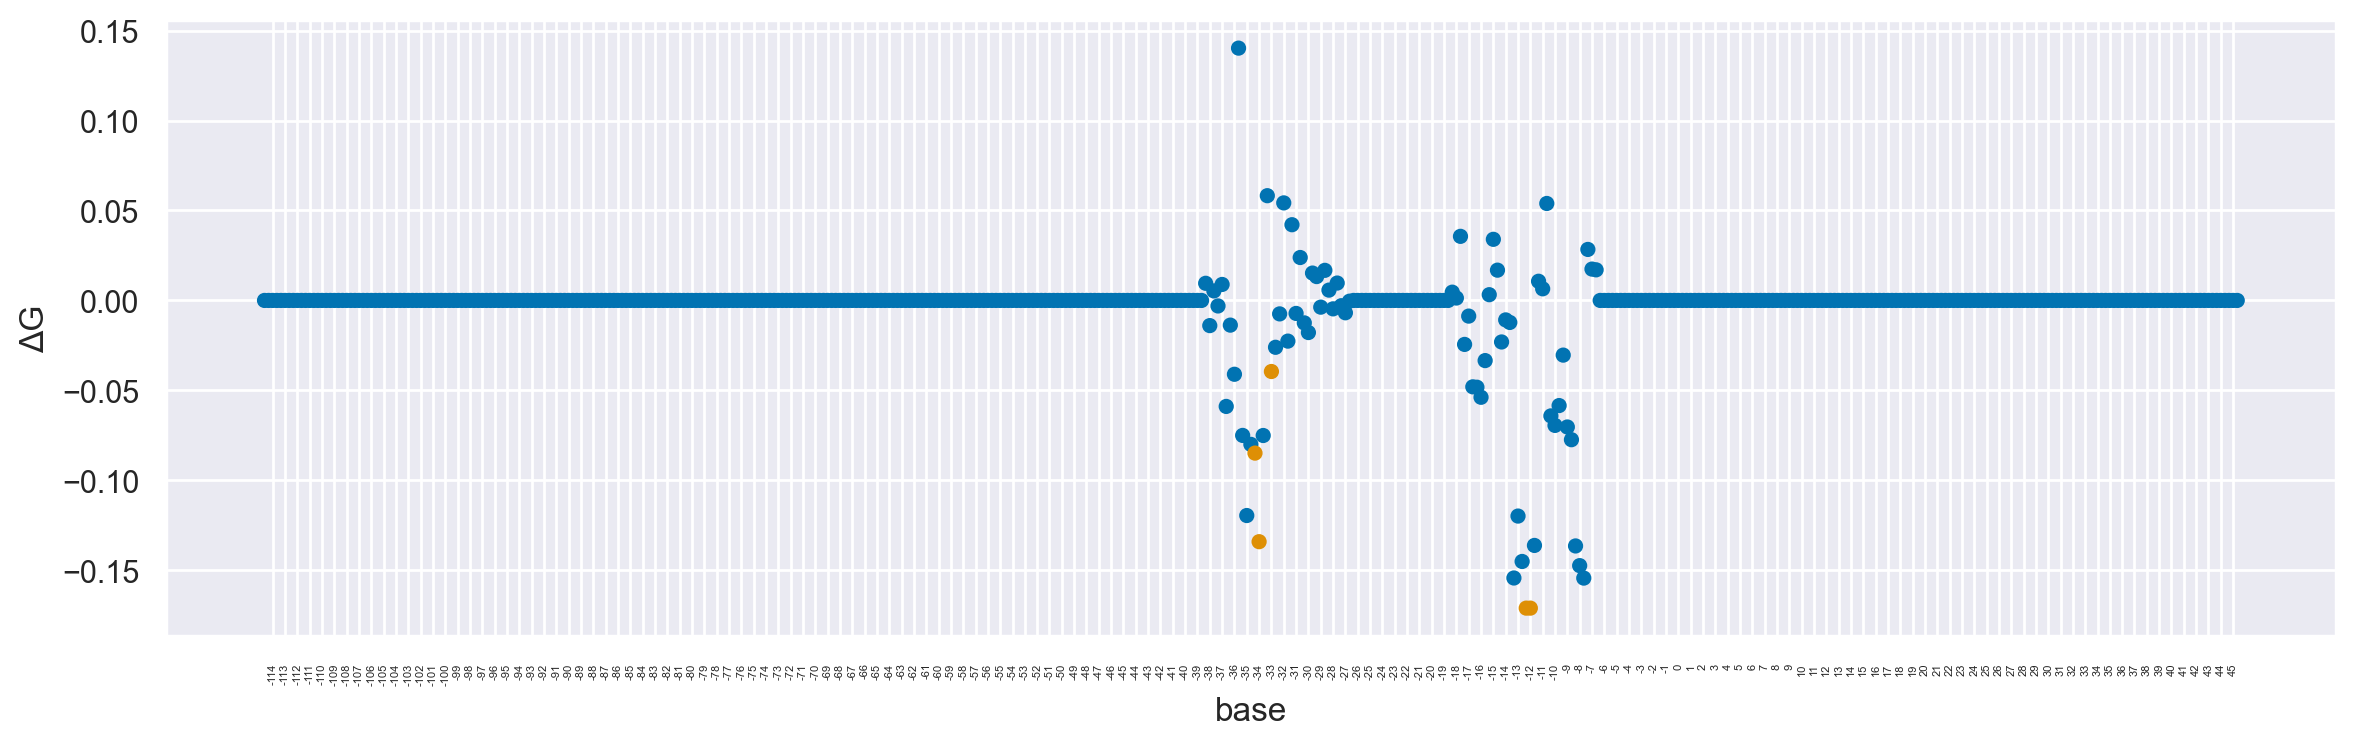

In [50]:
x = eval_lagator_single_mutation('ldrDp', 'Glucose')


color_dict = {
    1: sns.color_palette('colorblind')[0],
    0: sns.color_palette('colorblind')[1]
}

fig, ax = plt.subplots(figsize=(14, 4))
ax.scatter(x['index'], x['brick'], color=[color_dict[y] for y in x['same_TSS']], s=20)#, color=x['same_TSS'])
ax.set_ylabel("ΔG")
ax.set_xlabel("base")
ax.set_xticks(np.arange(2, 480, 3), [str(x - 115) for x in np.arange(1, 161)], fontsize=4, rotation=90);

Top 10 single mutations: 


,index,pos,wt_base,mut_base,brick,same_TSS
0,237,-37.0,G,T,0.140238,1
1,60,-96.0,A,T,0.077445,0
2,244,-34.0,C,A,0.058219,1
3,248,-33.0,T,C,0.054217,1
4,312,-12.0,G,T,0.053894,1
5,250,-32.0,G,A,0.042087,1
6,291,-19.0,A,T,0.035623,1
7,299,-16.0,C,G,0.033970,1
8,322,-8.0,C,A,0.028348,1
9,252,-32.0,G,T,0.023862,1


Highest observed expression shift: 


promoter                                              ldrDp
source                                               genome
expression_shift                                        1.0
growth_condition                                    Glucose
growth_condition_info    M9 Minimal Media with 0.5% Glucose
replicate                                                 1
pos                                                     -96
int_base                                                  4
wt_base                                                   A
base                                                      T
Name: 79, dtype: object

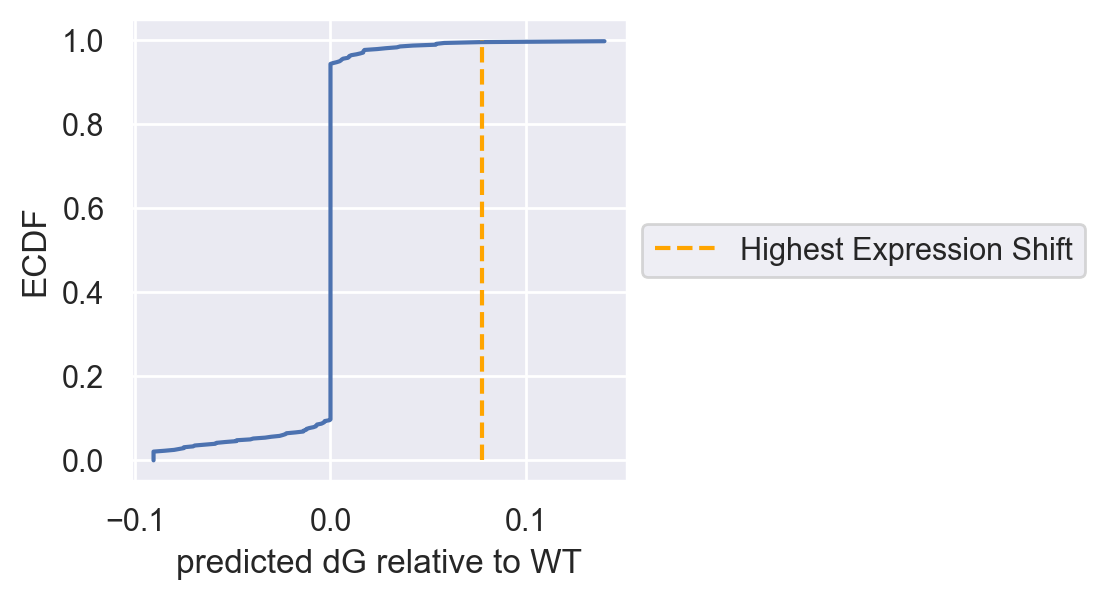

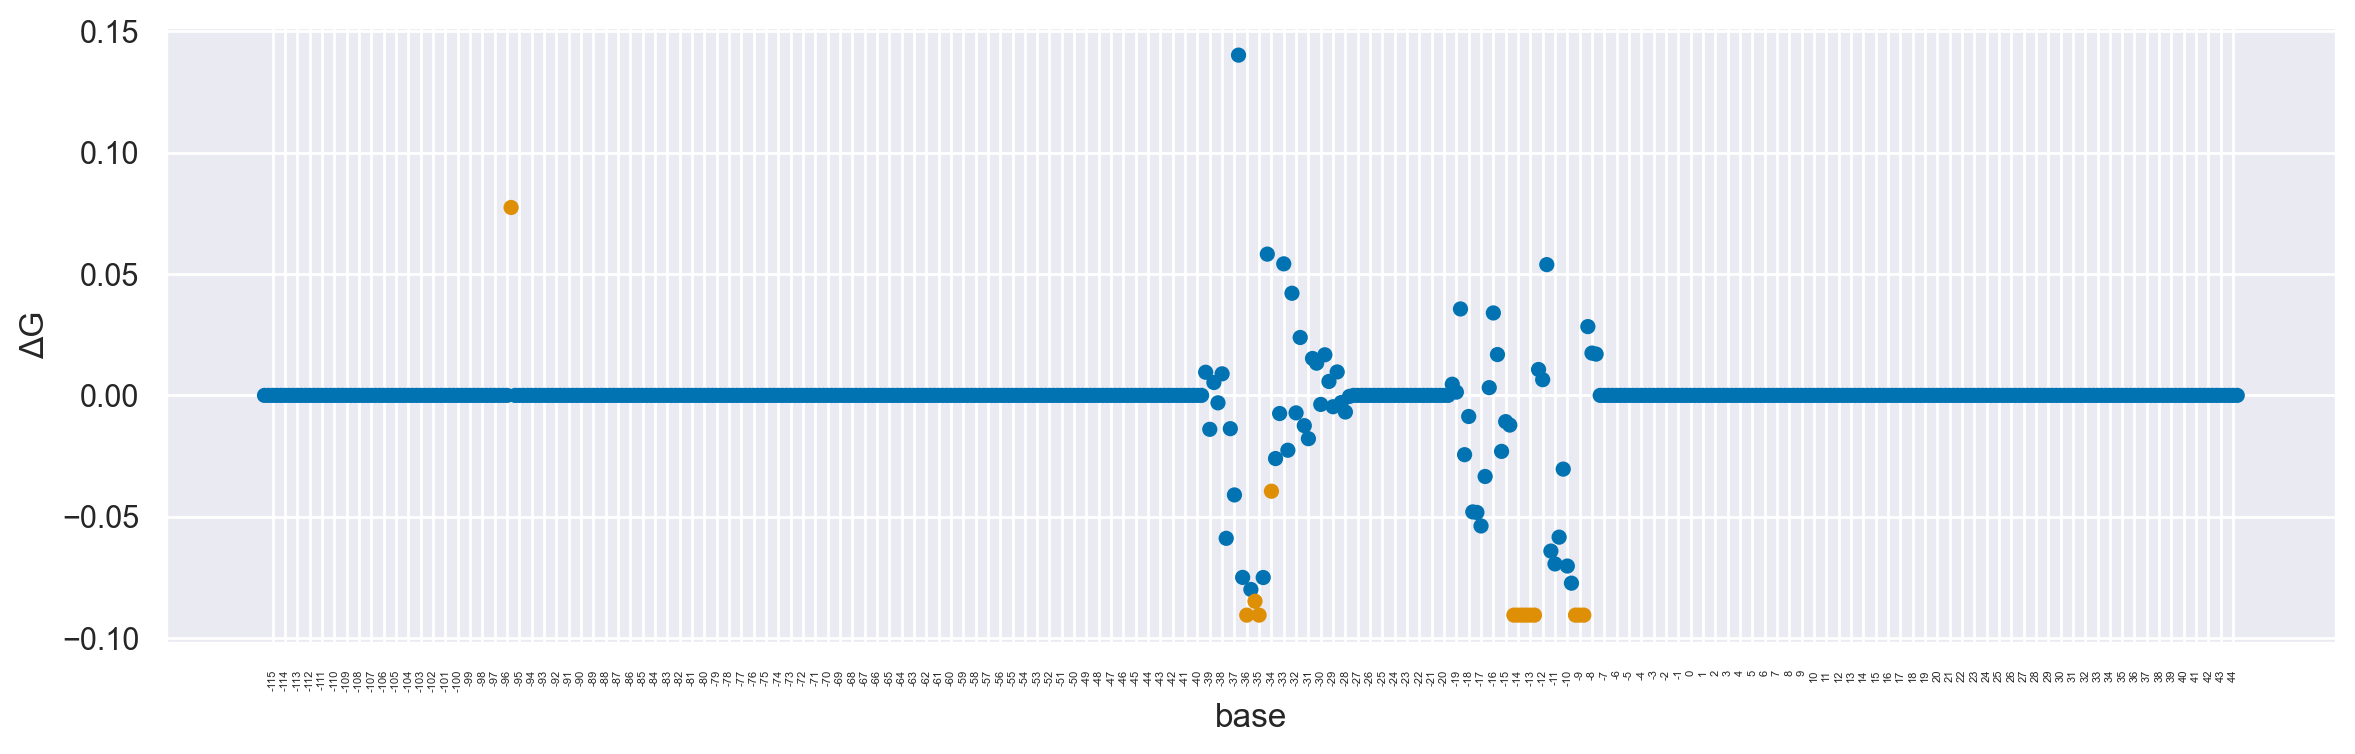

In [54]:
x = eval_lagator_single_mutation('ldrDp', 'Glucose', True)


color_dict = {
    1: sns.color_palette('colorblind')[0],
    0: sns.color_palette('colorblind')[1]
}

fig, ax = plt.subplots(figsize=(14, 4))
ax.scatter(x['index'], x['brick'], color=[color_dict[y] for y in x['same_TSS']], s=20)#, color=x['same_TSS'])
ax.set_ylabel("ΔG")
ax.set_xlabel("base")
ax.set_xticks(np.arange(2, 480, 3), [str(x - 116) for x in np.arange(1, 161)], fontsize=4, rotation=90);

In [14]:
df_test = get_reads('ldrDp')

In [15]:
df_test = df_test.groupby(['promoter'])[['ct_0', 'ct_1']].apply("mean").reset_index()

In [16]:
df_test['tag'] = df_test['promoter'].apply(lambda x: x[-96+115] == 'T')
df_test.groupby('tag')[['ct_0', 'ct_1']].apply("mean")

,ct_0,ct_1
tag,,
False,1.115931,0.760251
True,1.004857,1.544690


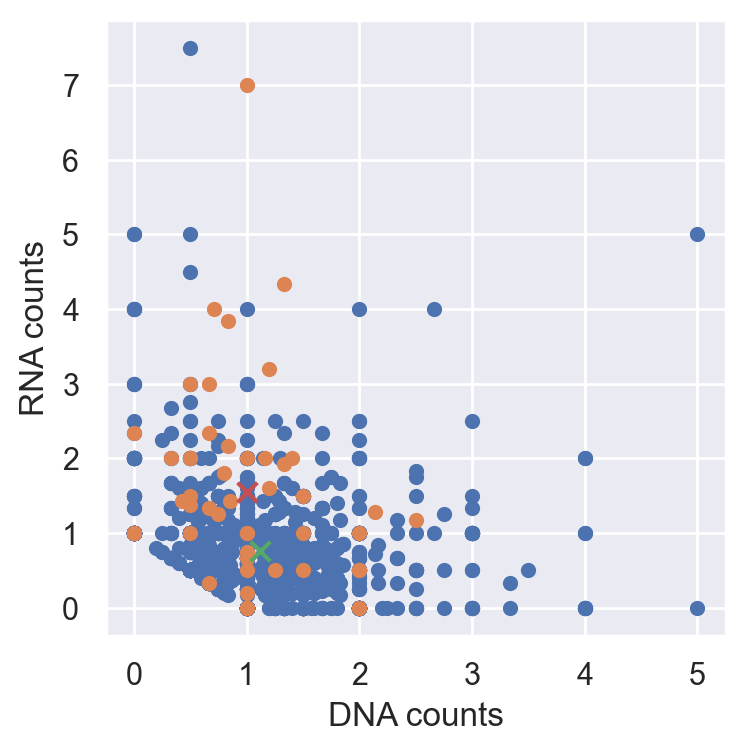

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.set_xlabel("DNA counts")
ax.set_ylabel("RNA counts")

for _, group in df_test.groupby('tag'):
    plt.scatter(group['ct_0'], group['ct_1'], s=20)

df_mean = df_test.groupby('tag')[['ct_0', 'ct_1']].apply("mean").reset_index()

for _, group in df_mean.groupby('tag'):
    plt.scatter(group['ct_0'], group['ct_1'], s=50, marker='x')


### ghoSp

Top 10 single mutations: 


,index,pos,wt_base,mut_base,brick,same_TSS
0,217,-43.0,C,A,0.173463,0
1,462,38.0,A,T,0.147197,1
2,148,-66.0,T,A,0.110192,0
3,384,12.0,T,G,0.074716,1
4,369,7.0,G,T,0.071020,0
5,372,8.0,C,T,0.069634,0
6,457,37.0,G,A,0.069594,1
7,454,36.0,G,A,0.068649,1
8,314,-11.0,A,G,0.064863,0
9,388,14.0,A,C,0.056588,1


Highest observed expression shift: 


promoter                                              ghoSp
source                                               genome
expression_shift                                        1.0
growth_condition                                    Glucose
growth_condition_info    M9 Minimal Media with 0.5% Glucose
replicate                                                 1
pos                                                     -43
int_base                                                  1
wt_base                                                   C
base                                                      A
Name: 288, dtype: object

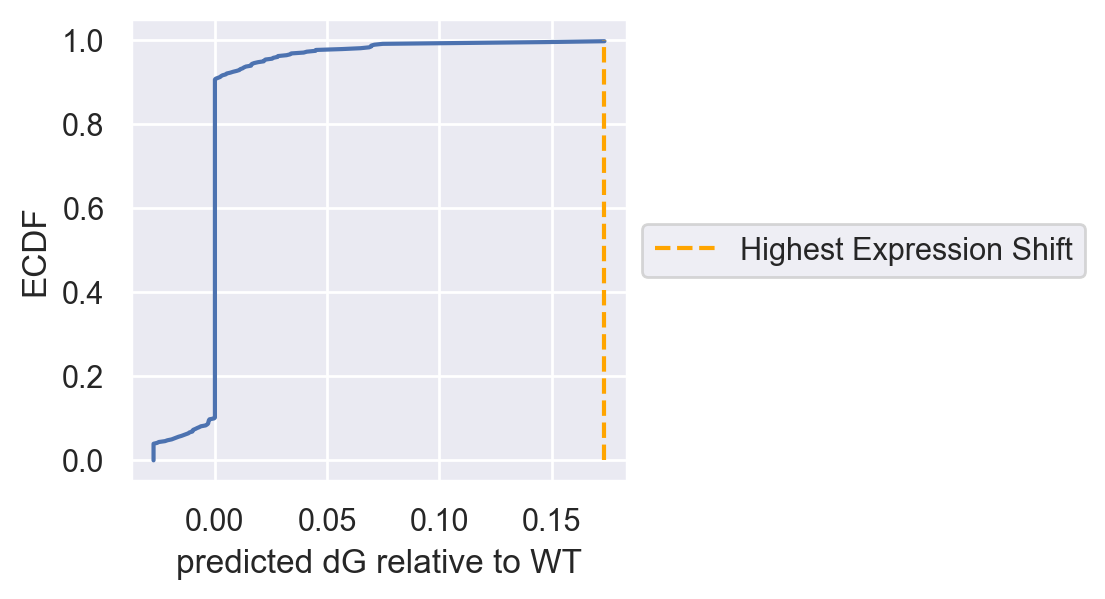

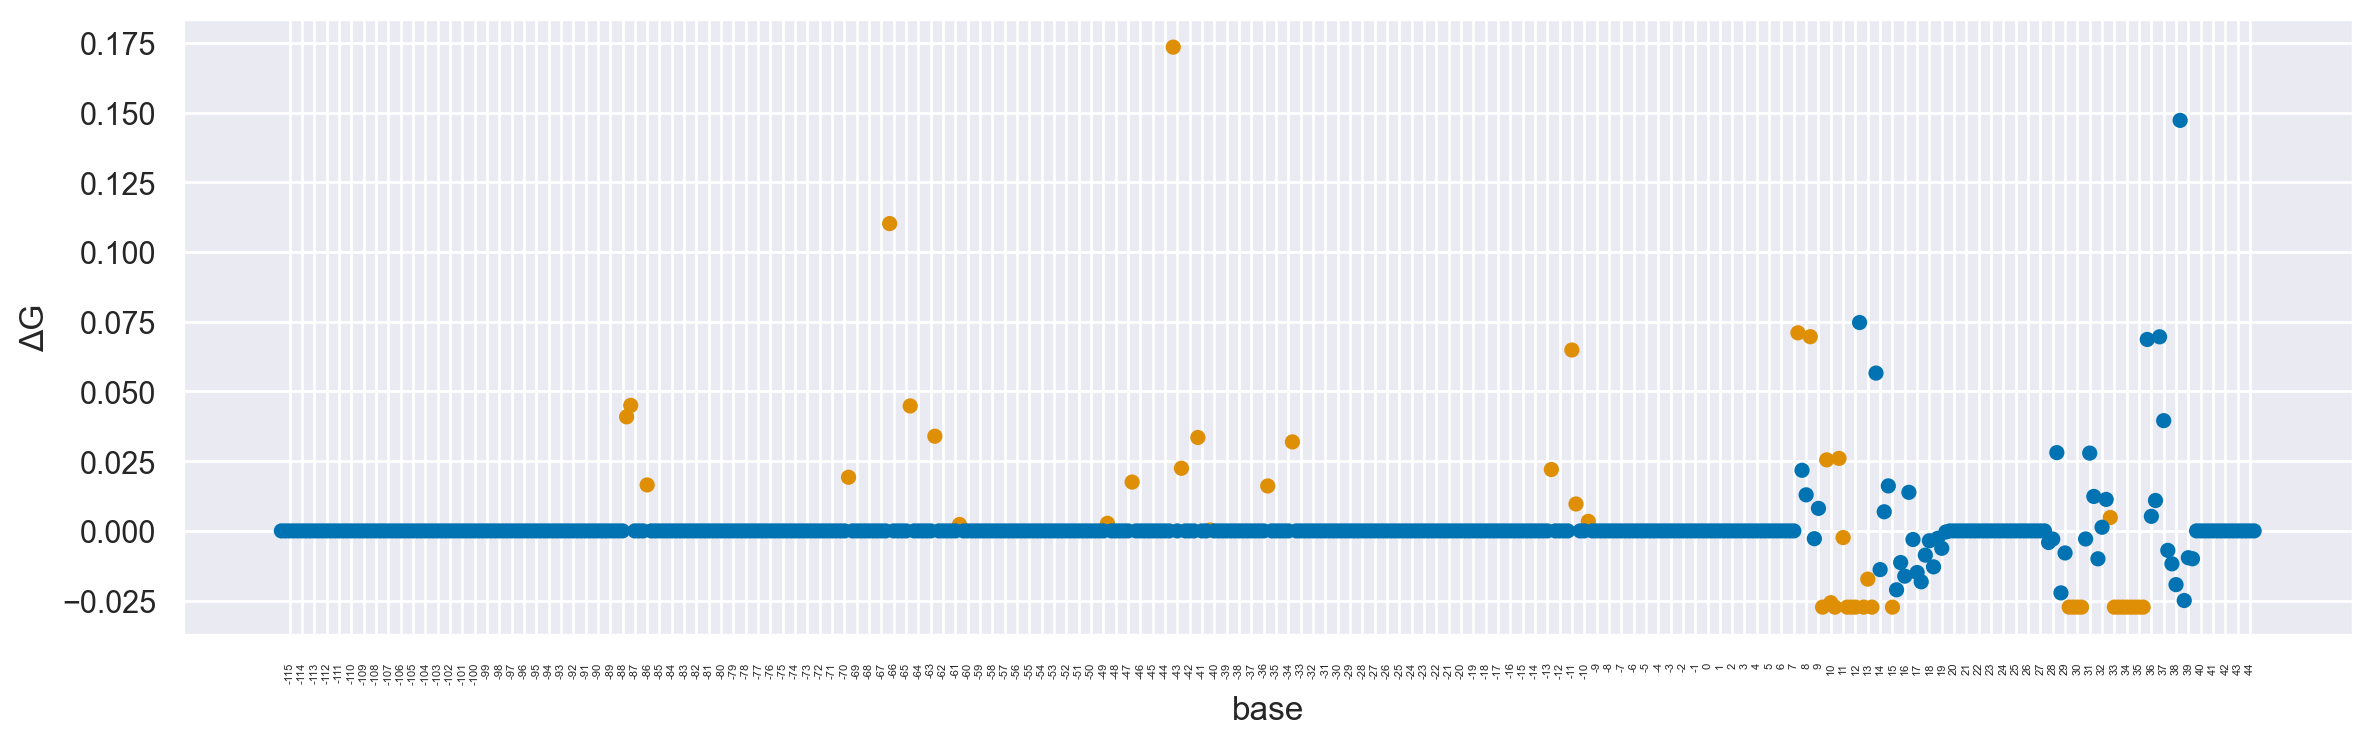

In [53]:
x = eval_lagator_single_mutation('ghoSp')

color_dict = {
    1: sns.color_palette('colorblind')[0],
    0: sns.color_palette('colorblind')[1]
}

fig, ax = plt.subplots(figsize=(14, 4))
ax.scatter(x['index'], x['brick'], color=[color_dict[y] for y in x['same_TSS']], s=20)#, color=x['same_TSS'])
ax.set_ylabel("ΔG")
ax.set_xlabel("base")
ax.set_xticks(np.arange(2, 480, 3), [str(x - 116) for x in np.arange(1, 161)], fontsize=4, rotation=90);

### araBp

Top 10 single mutations: 


,index,pos,wt_base,mut_base,brick,same_TSS
0,94,-84.0,T,A,0.151636,1
1,231,-39.0,C,T,0.075352,0
2,100,-82.0,G,A,0.070896,1
3,298,-16.0,C,A,0.066519,0
4,84,-88.0,C,T,0.053879,1
5,32,-105.0,T,C,0.050916,1
6,115,-77.0,G,A,0.032405,0
7,103,-81.0,C,A,0.029573,1
8,78,-90.0,C,T,0.028988,1
9,86,-87.0,A,G,0.028798,1


Highest observed expression shift: 


promoter                                              araBp
source                                               genome
expression_shift                                        1.0
growth_condition                                    Glucose
growth_condition_info    M9 Minimal Media with 0.5% Glucose
replicate                                                 1
pos                                                     -77
int_base                                                  1
wt_base                                                   G
base                                                      A
Name: 152, dtype: object

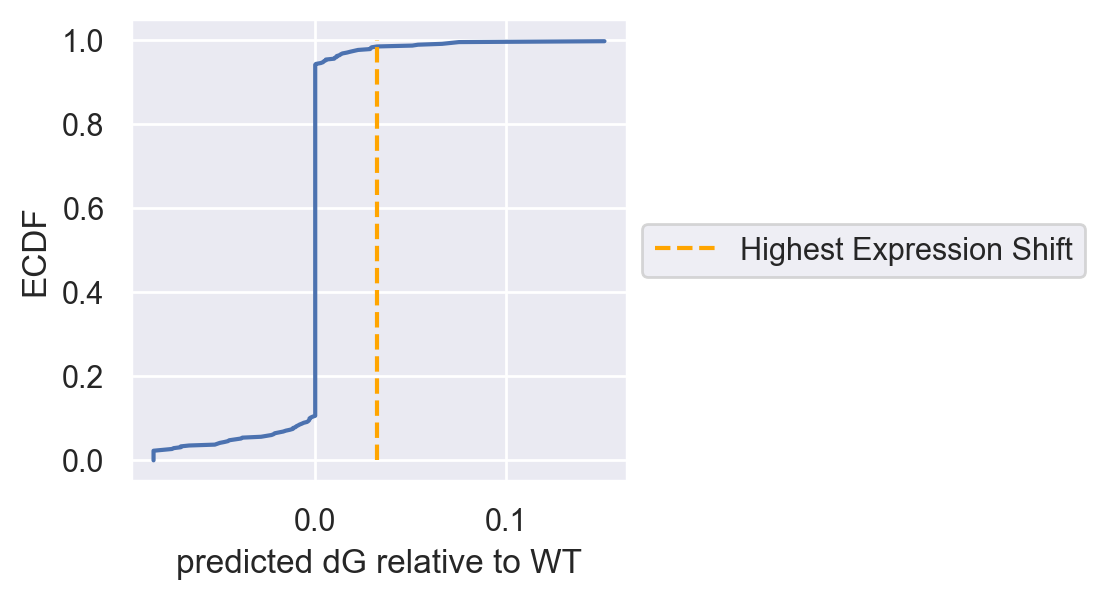

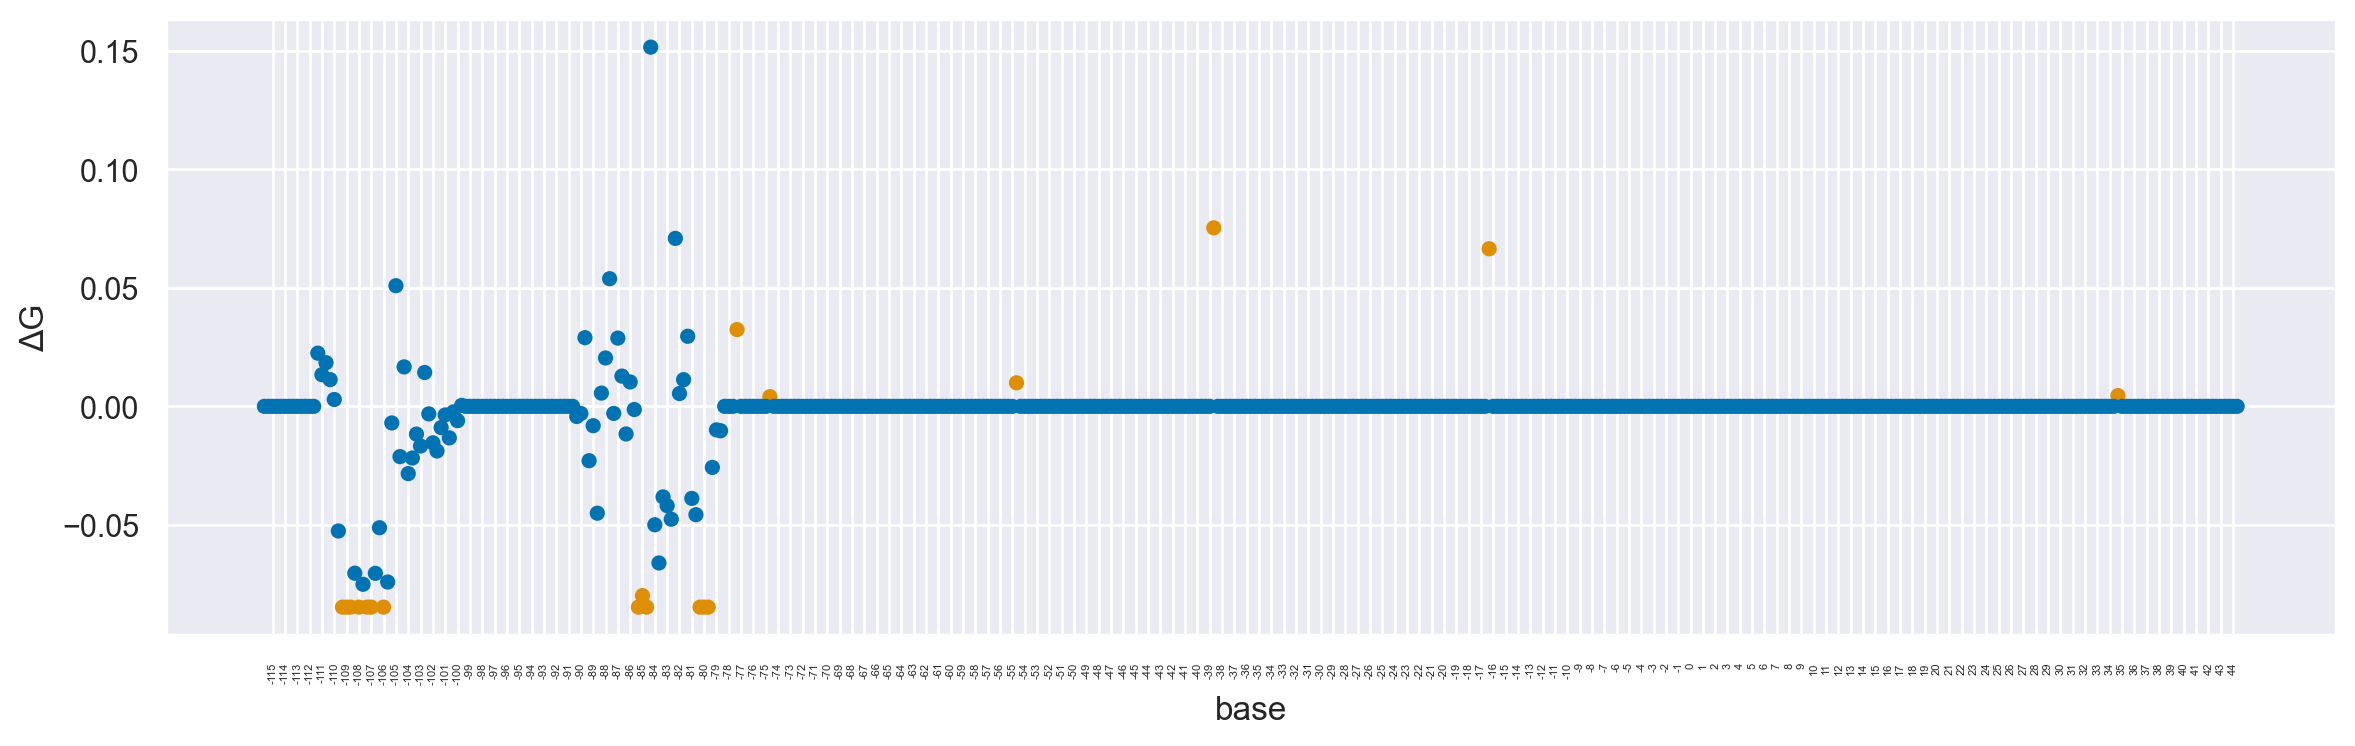

In [55]:
x = eval_lagator_single_mutation('araBp')


color_dict = {
    1: sns.color_palette('colorblind')[0],
    0: sns.color_palette('colorblind')[1]
}

fig, ax = plt.subplots(figsize=(14, 4))
ax.scatter(x['index'], x['brick'], color=[color_dict[y] for y in x['same_TSS']], s=20)#, color=x['same_TSS'])
ax.set_ylabel("ΔG")
ax.set_xlabel("base")
ax.set_xticks(np.arange(2, 480, 3), [str(x - 116) for x in np.arange(1, 161)], fontsize=4, rotation=90);

### cpxRp2

Top 10 single mutations: 


,index,pos,wt_base,mut_base,brick,same_TSS
0,129,-73.0,A,T,0.091651,0
1,243,-35.0,G,T,0.083796,1
2,319,-9.0,T,A,0.080804,1
3,316,-10.0,T,A,0.059575,1
4,117,-77.0,C,T,0.058023,0
5,251,-32.0,T,C,0.051563,1
6,320,-9.0,T,C,0.049077,1
7,300,-16.0,A,T,0.048576,1
8,201,-49.0,C,T,0.047370,0
9,378,10.0,A,T,0.042539,0


Highest observed expression shift: 


promoter                                             cpxRp2
source                                               genome
expression_shift                                        1.0
growth_condition                                    Glucose
growth_condition_info    M9 Minimal Media with 0.5% Glucose
replicate                                                 1
pos                                                     -77
int_base                                                  4
wt_base                                                   C
base                                                      T
Name: 155, dtype: object

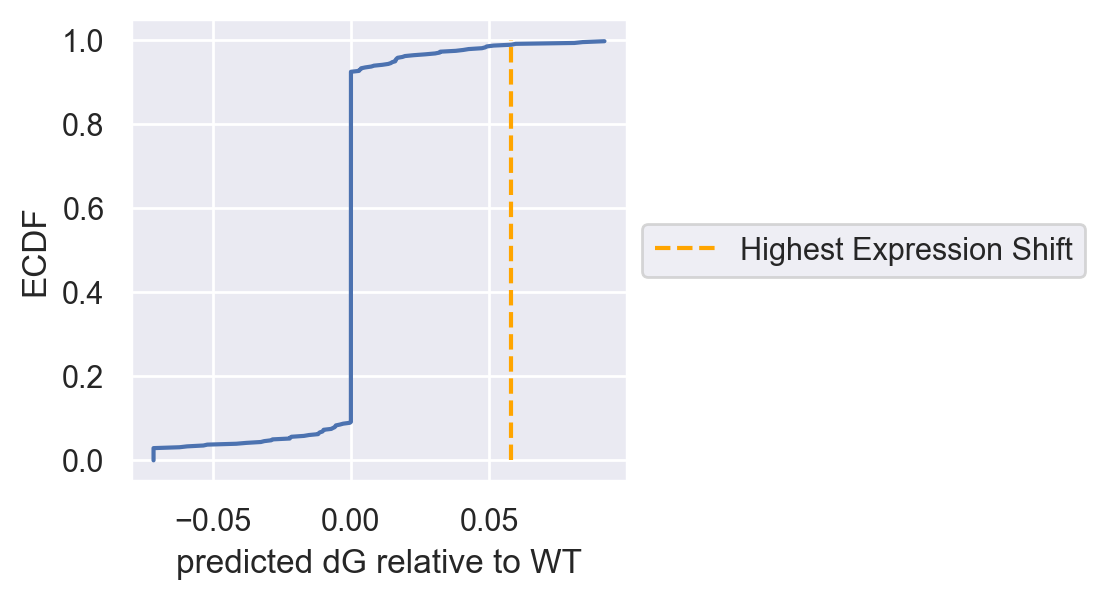

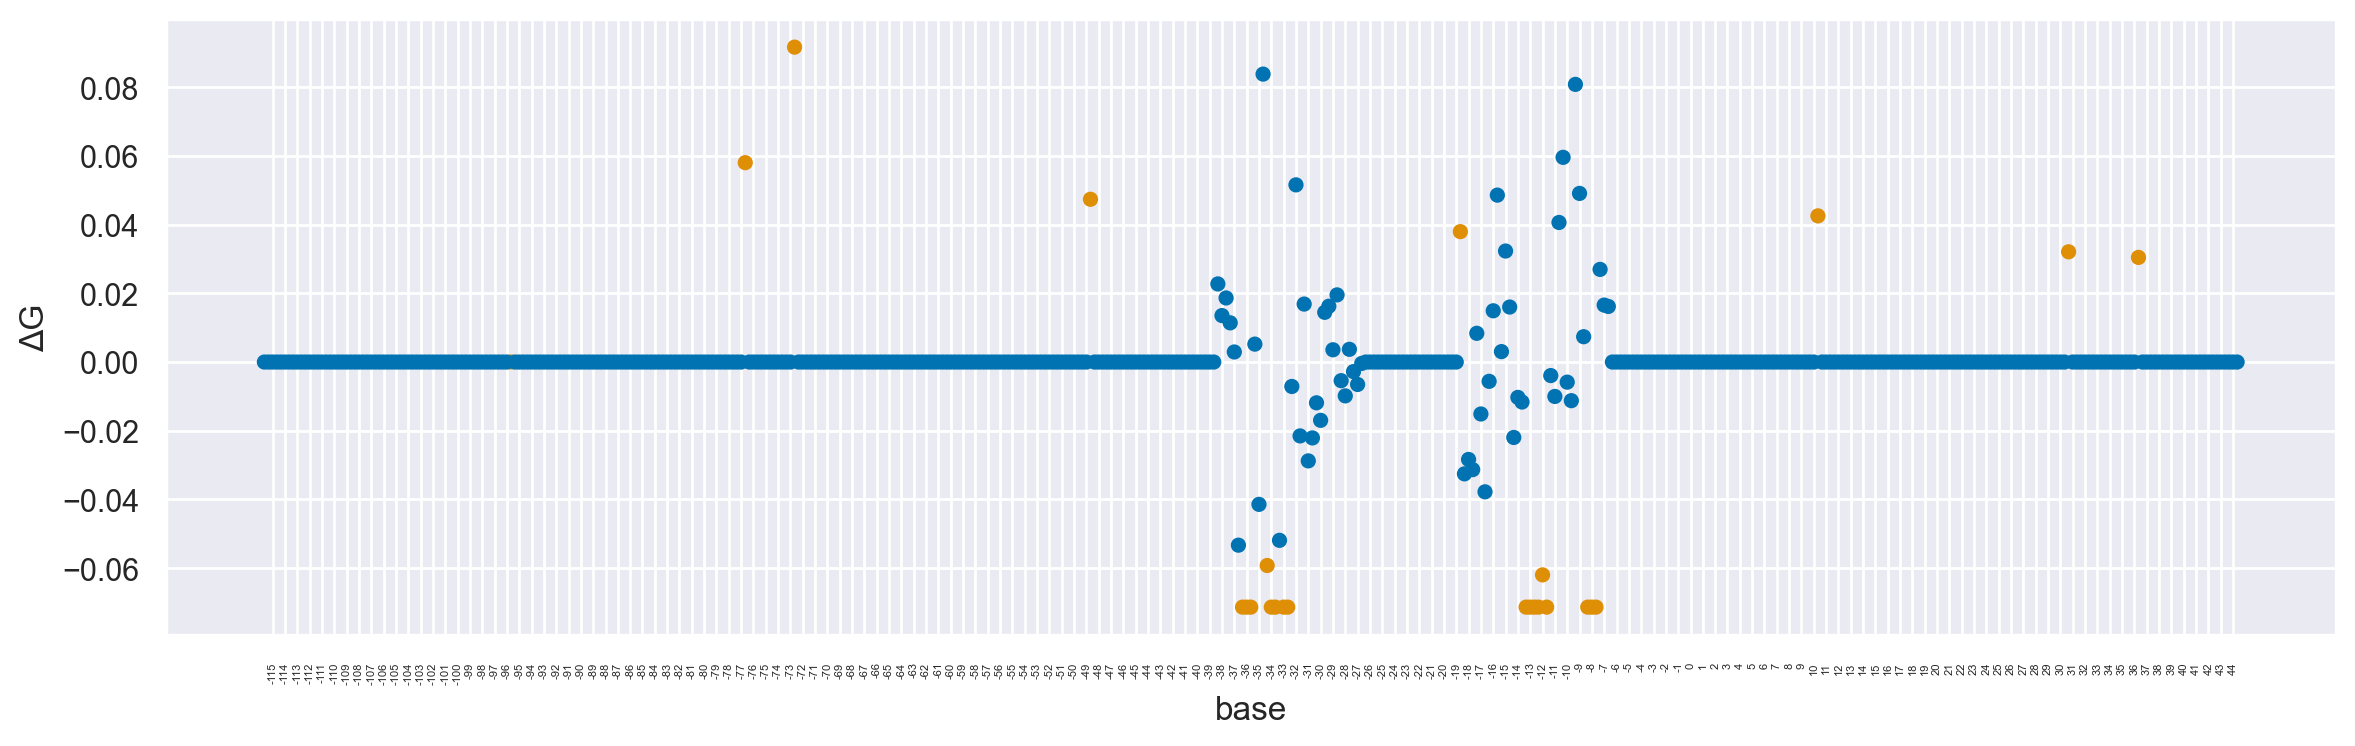

In [56]:
x = eval_lagator_single_mutation('cpxRp2')

color_dict = {
    1: sns.color_palette('colorblind')[0],
    0: sns.color_palette('colorblind')[1]
}

fig, ax = plt.subplots(figsize=(14, 4))
ax.scatter(x['index'], x['brick'], color=[color_dict[y] for y in x['same_TSS']], s=20)#, color=x['same_TSS'])
ax.set_ylabel("ΔG")
ax.set_xlabel("base")
ax.set_xticks(np.arange(2, 480, 3), [str(x - 116) for x in np.arange(1, 161)], fontsize=4, rotation=90);

### mhpRp1

Top 10 single mutations: 


,index,pos,wt_base,mut_base,brick,same_TSS
0,314,-11.0,A,G,0.201491,1
1,370,8.0,T,A,0.130724,0
2,315,-11.0,A,T,0.112243,1
3,373,9.0,T,A,0.088993,0
4,388,14.0,G,A,0.073246,1
5,307,-13.0,T,A,0.061041,0
6,435,29.0,G,T,0.060556,0
7,385,13.0,T,A,0.059953,1
8,319,-9.0,A,C,0.059558,1
9,364,6.0,T,A,0.048653,1


Highest observed expression shift: 


promoter                                                            mhpRp1
source                                                              genome
expression_shift                                                       1.0
growth_condition                                                Spermidine
growth_condition_info    M9 Minimal Media with 0.5% Glucose to steady s...
replicate                                                                1
pos                                                                      8
int_base                                                                 1
wt_base                                                                  T
base                                                                     A
Name: 492, dtype: object

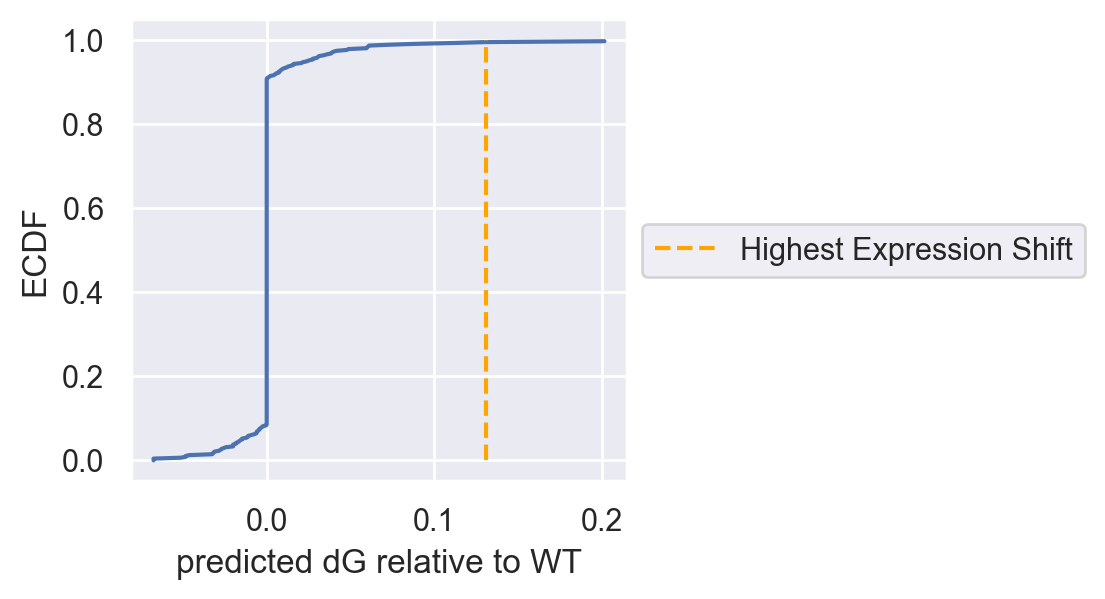

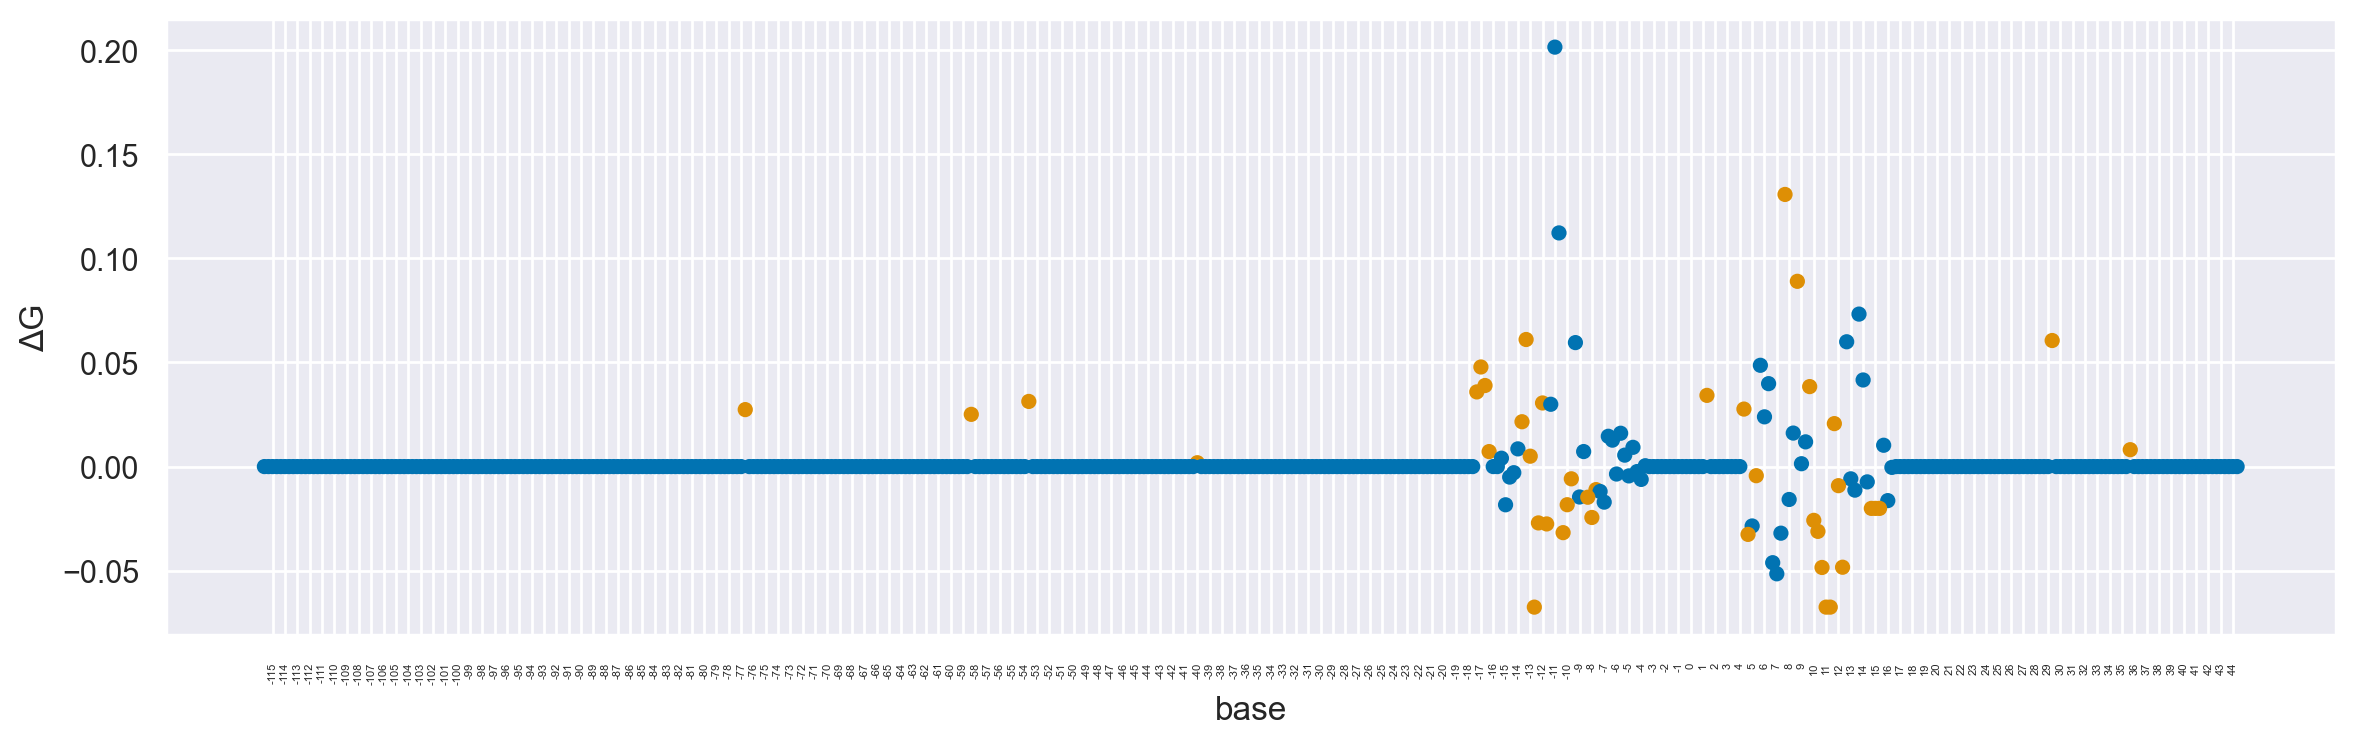

In [57]:
x = eval_lagator_single_mutation('mhpRp1', 'Spermidine')


color_dict = {
    1: sns.color_palette('colorblind')[0],
    0: sns.color_palette('colorblind')[1]
}

fig, ax = plt.subplots(figsize=(14, 4))
ax.scatter(x['index'], x['brick'], color=[color_dict[y] for y in x['same_TSS']], s=20)#, color=x['same_TSS'])
ax.set_ylabel("ΔG")
ax.set_xlabel("base")
ax.set_xticks(np.arange(2, 480, 3), [str(x - 116) for x in np.arange(1, 161)], fontsize=4, rotation=90);

### rcsBp1

Top 10 single mutations: 


,index,pos,wt_base,mut_base,brick,same_TSS
0,234,-38.0,A,T,0.162092,1
1,310,-12.0,G,A,0.078226,1
2,244,-34.0,A,C,0.064482,1
3,246,-34.0,A,T,0.045578,0
4,288,-20.0,A,T,0.036912,1
5,294,-18.0,G,T,0.036027,1
6,252,-32.0,G,T,0.034966,1
7,296,-17.0,A,G,0.031775,1
8,226,-40.0,C,A,0.024766,1
9,228,-40.0,C,T,0.020316,1


Highest observed expression shift: 


promoter                                             rcsBp1
source                                               genome
expression_shift                                        1.0
growth_condition                                    Glucose
growth_condition_info    M9 Minimal Media with 0.5% Glucose
replicate                                                 1
pos                                                     -38
int_base                                                  4
wt_base                                                   A
base                                                      T
Name: 311, dtype: object

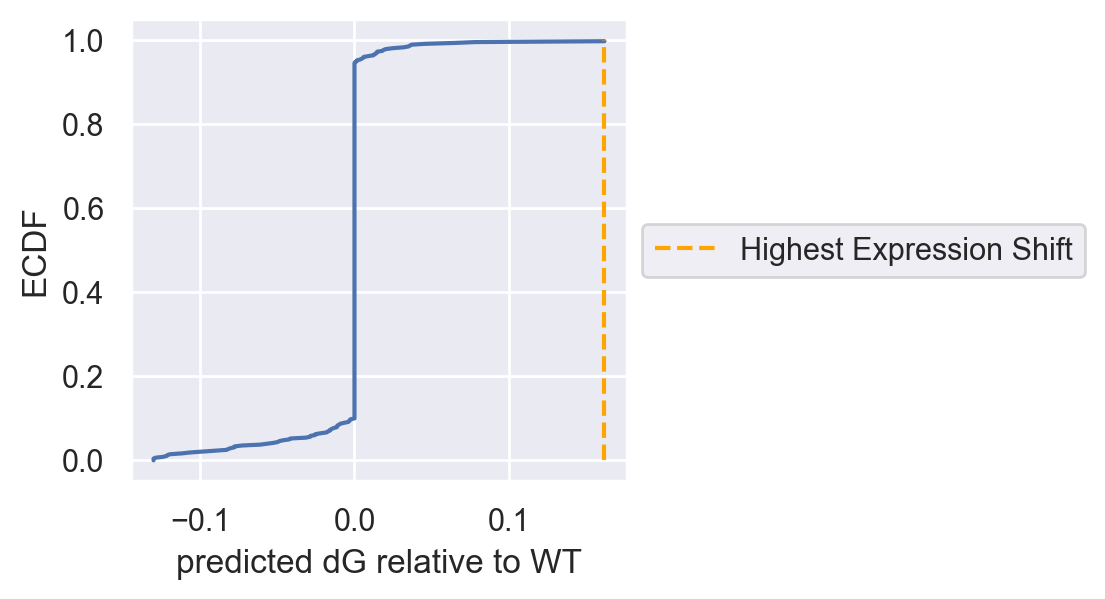

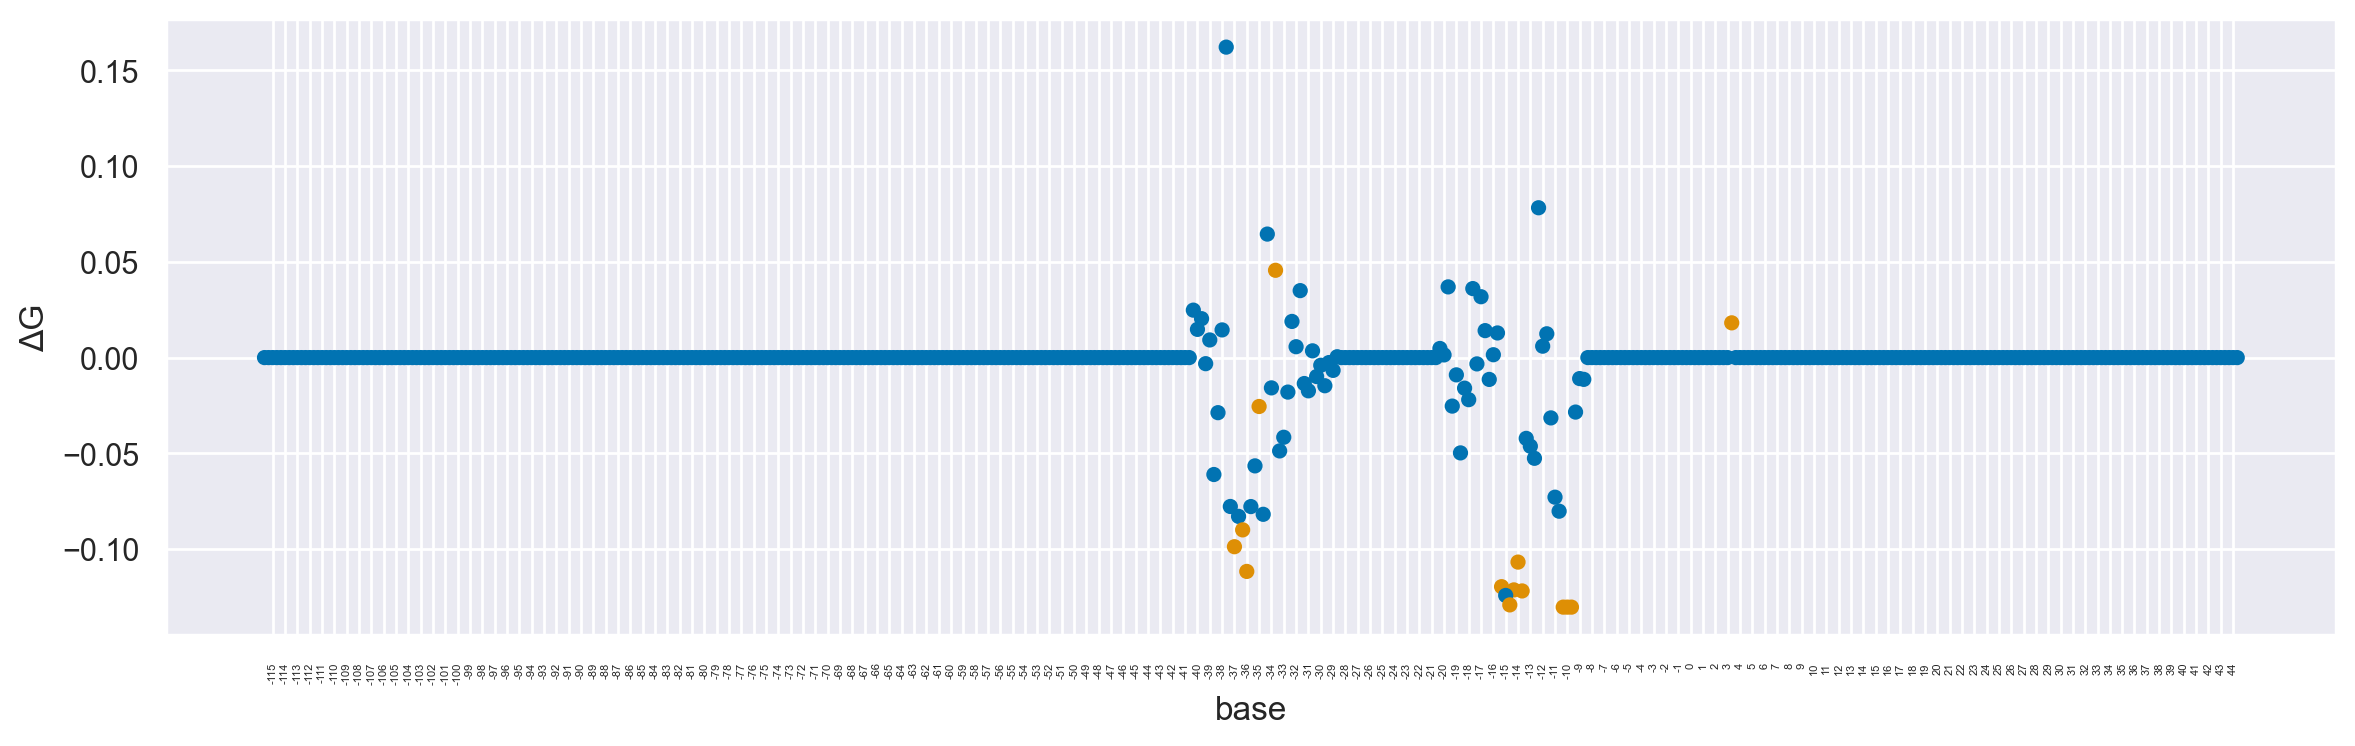

In [58]:
x = eval_lagator_single_mutation('rcsBp1')


color_dict = {
    1: sns.color_palette('colorblind')[0],
    0: sns.color_palette('colorblind')[1]
}

fig, ax = plt.subplots(figsize=(14, 4))
ax.scatter(x['index'], x['brick'], color=[color_dict[y] for y in x['same_TSS']], s=20)#, color=x['same_TSS'])
ax.set_ylabel("ΔG")
ax.set_xlabel("base")
ax.set_xticks(np.arange(2, 480, 3), [str(x - 116) for x in np.arange(1, 161)], fontsize=4, rotation=90);

### tolCp1

Top 10 single mutations: 


,index,pos,wt_base,mut_base,brick,same_TSS
0,228,-40.0,C,T,0.199834,1
1,307,-13.0,T,A,0.089242,1
2,235,-37.0,C,A,0.061150,1
3,308,-13.0,T,C,0.054202,1
4,227,-40.0,C,G,0.045237,1
5,303,-15.0,A,T,0.044859,1
6,241,-35.0,G,A,0.044206,1
7,226,-40.0,C,A,0.030110,1
8,243,-35.0,G,T,0.025064,1
9,136,-70.0,G,A,0.014517,0


Highest observed expression shift: 


promoter                                             tolCp1
source                                               genome
expression_shift                                        1.0
growth_condition                                    Glucose
growth_condition_info    M9 Minimal Media with 0.5% Glucose
replicate                                                 1
pos                                                     -40
int_base                                                  4
wt_base                                                   C
base                                                      T
Name: 303, dtype: object

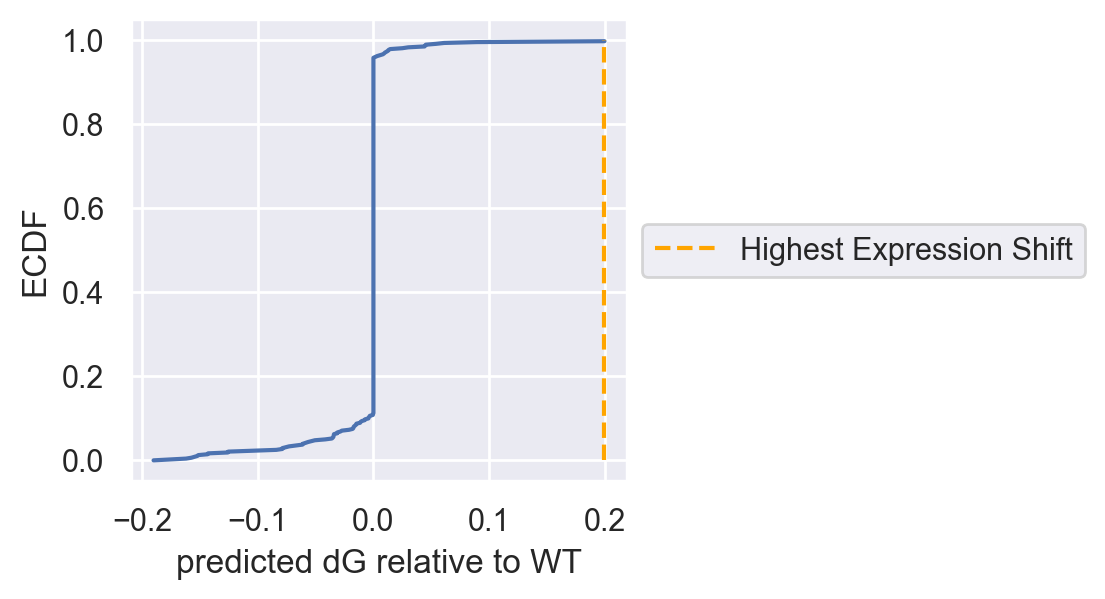

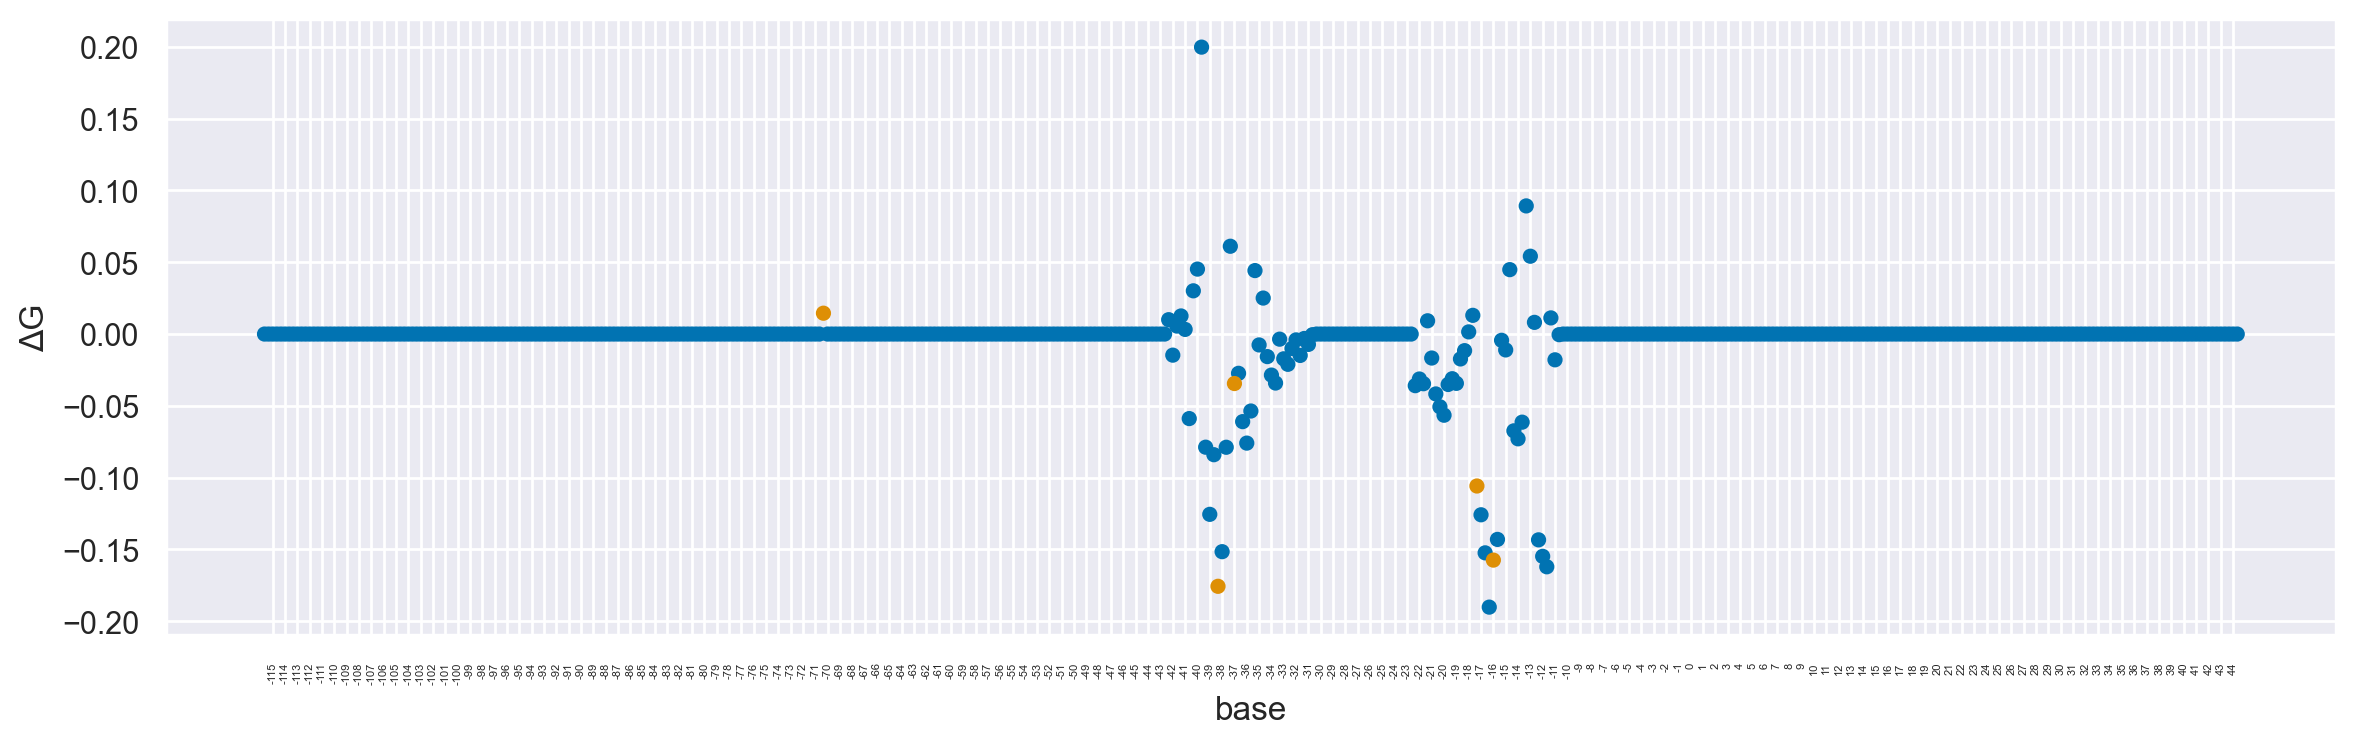

In [59]:
x = eval_lagator_single_mutation('tolCp1')


color_dict = {
    1: sns.color_palette('colorblind')[0],
    0: sns.color_palette('colorblind')[1]
}

fig, ax = plt.subplots(figsize=(14, 4))
ax.scatter(x['index'], x['brick'], color=[color_dict[y] for y in x['same_TSS']], s=20)#, color=x['same_TSS'])
ax.set_ylabel("ΔG")
ax.set_xlabel("base")
ax.set_xticks(np.arange(2, 480, 3), [str(x - 116) for x in np.arange(1, 161)], fontsize=4, rotation=90);

### tolCp3

Top 10 single mutations: 


,index,pos,wt_base,mut_base,brick,same_TSS
0,54,-98.0,C,T,0.199834,1
1,133,-71.0,T,A,0.089242,1
2,61,-95.0,C,A,0.061150,1
3,134,-71.0,T,C,0.054202,1
4,53,-98.0,C,G,0.045237,1
5,129,-73.0,A,T,0.044859,1
6,67,-93.0,G,A,0.044206,1
7,345,-1.0,A,T,0.041676,0
8,385,13.0,T,A,0.030286,0
9,52,-98.0,C,A,0.030110,1


Highest observed expression shift: 


promoter                                             tolCp3
source                                               genome
expression_shift                                        1.0
growth_condition                                    Glucose
growth_condition_info    M9 Minimal Media with 0.5% Glucose
replicate                                                 1
pos                                                     -98
int_base                                                  4
wt_base                                                   C
base                                                      T
Name: 71, dtype: object

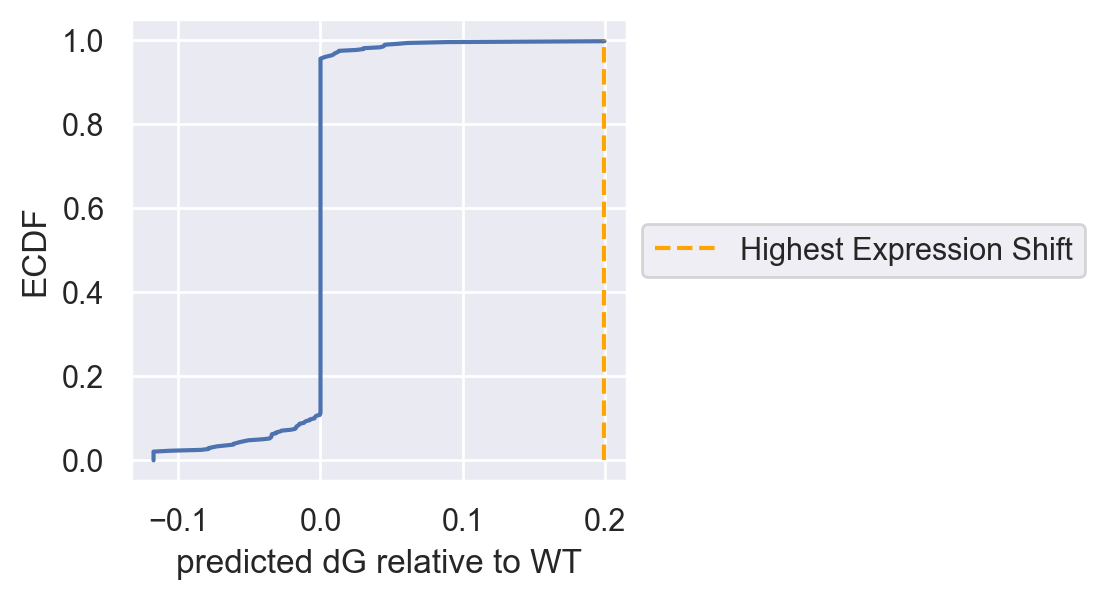

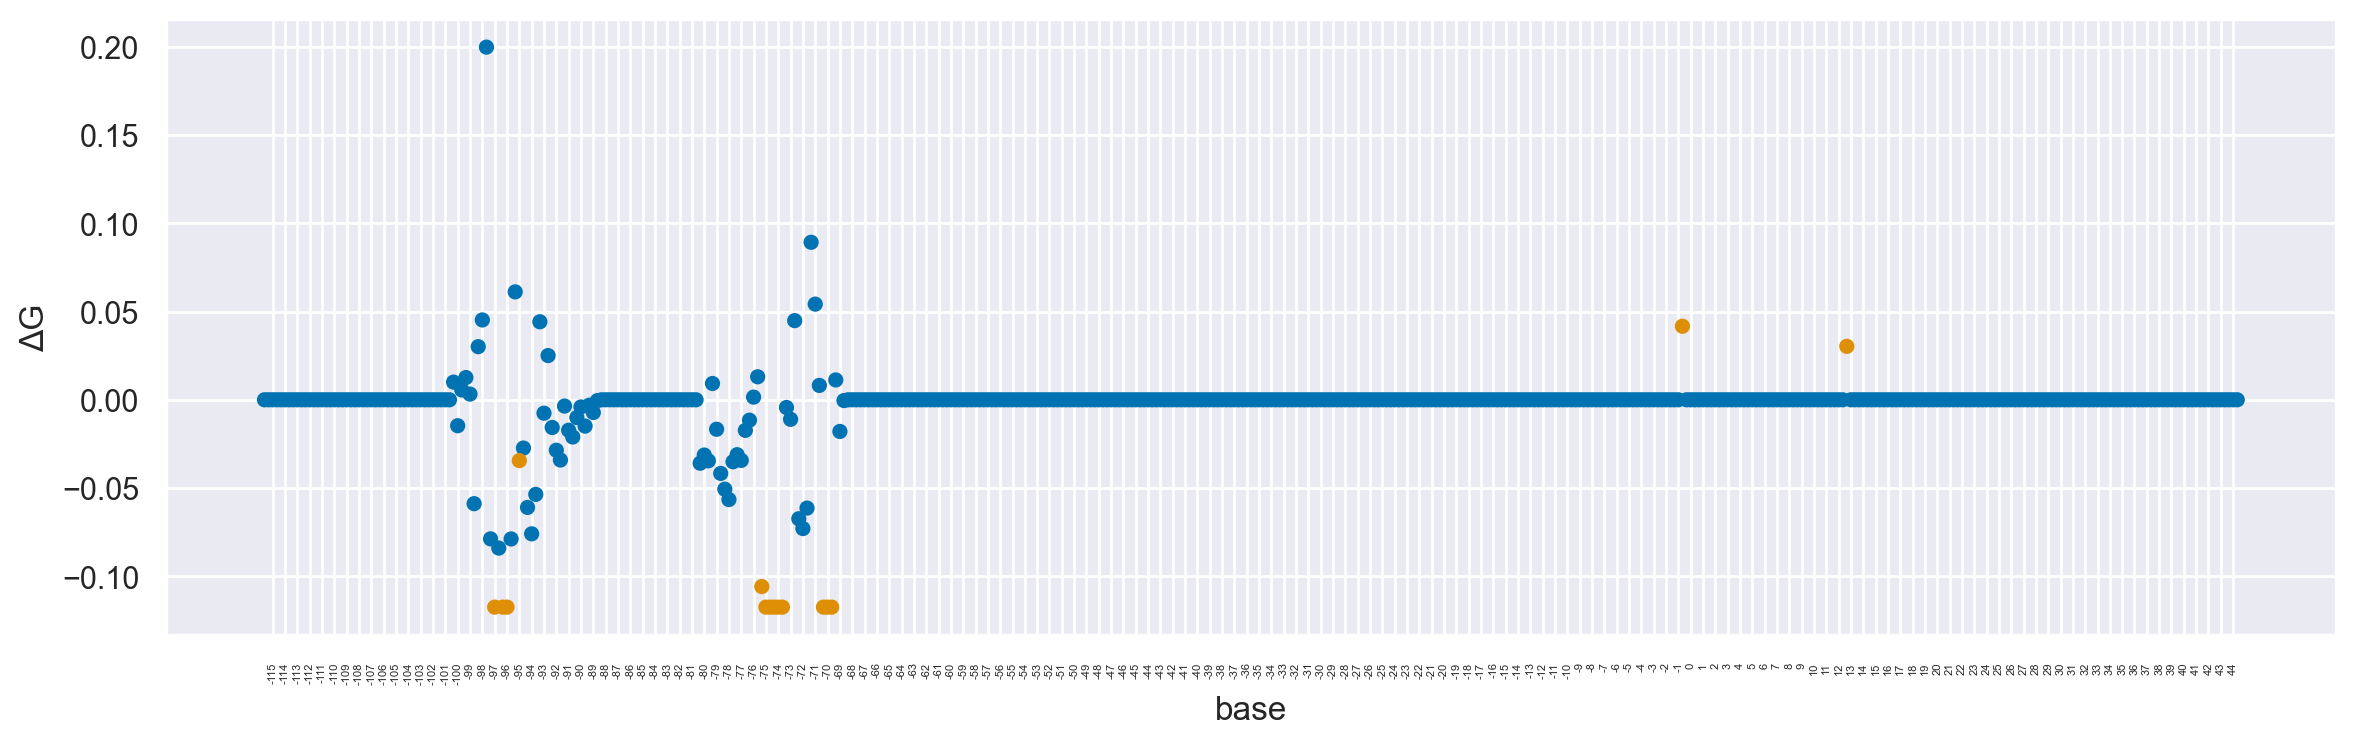

In [60]:
x = eval_lagator_single_mutation('tolCp3')


color_dict = {
    1: sns.color_palette('colorblind')[0],
    0: sns.color_palette('colorblind')[1]
}

fig, ax = plt.subplots(figsize=(14, 4))
ax.scatter(x['index'], x['brick'], color=[color_dict[y] for y in x['same_TSS']], s=20)#, color=x['same_TSS'])
ax.set_ylabel("ΔG")
ax.set_xlabel("base")
ax.set_xticks(np.arange(2, 480, 3), [str(x - 116) for x in np.arange(1, 161)], fontsize=4, rotation=90);

### xylAp

Top 10 single mutations: 


,index,pos,wt_base,mut_base,brick,same_TSS
0,202,-48.0,G,A,0.228829,0
1,312,-12.0,A,T,0.172435,1
2,309,-13.0,C,T,0.126864,0
3,155,-64.0,A,G,0.111740,0
4,147,-67.0,A,T,0.108744,0
5,144,-68.0,A,T,0.097210,0
6,322,-8.0,T,A,0.078114,1
7,136,-70.0,T,A,0.077168,0
8,251,-32.0,G,C,0.072518,1
9,140,-69.0,G,C,0.069852,0


Highest observed expression shift: 


promoter                                              xylAp
source                                               genome
expression_shift                                        1.0
growth_condition                                    Glucose
growth_condition_info    M9 Minimal Media with 0.5% Glucose
replicate                                                 1
pos                                                     -68
int_base                                                  4
wt_base                                                   A
base                                                      T
Name: 191, dtype: object

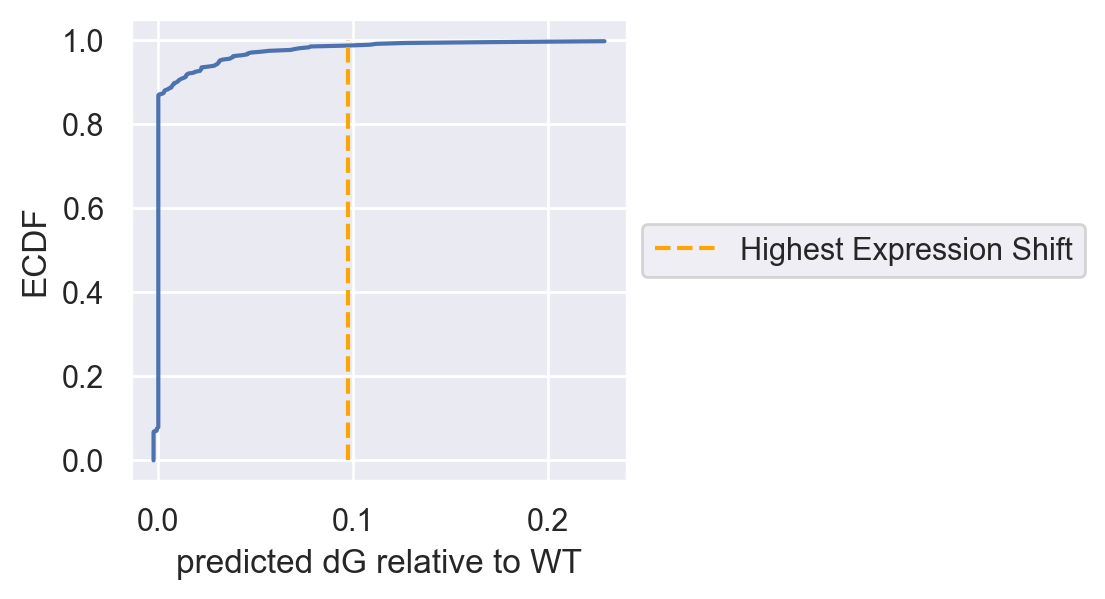

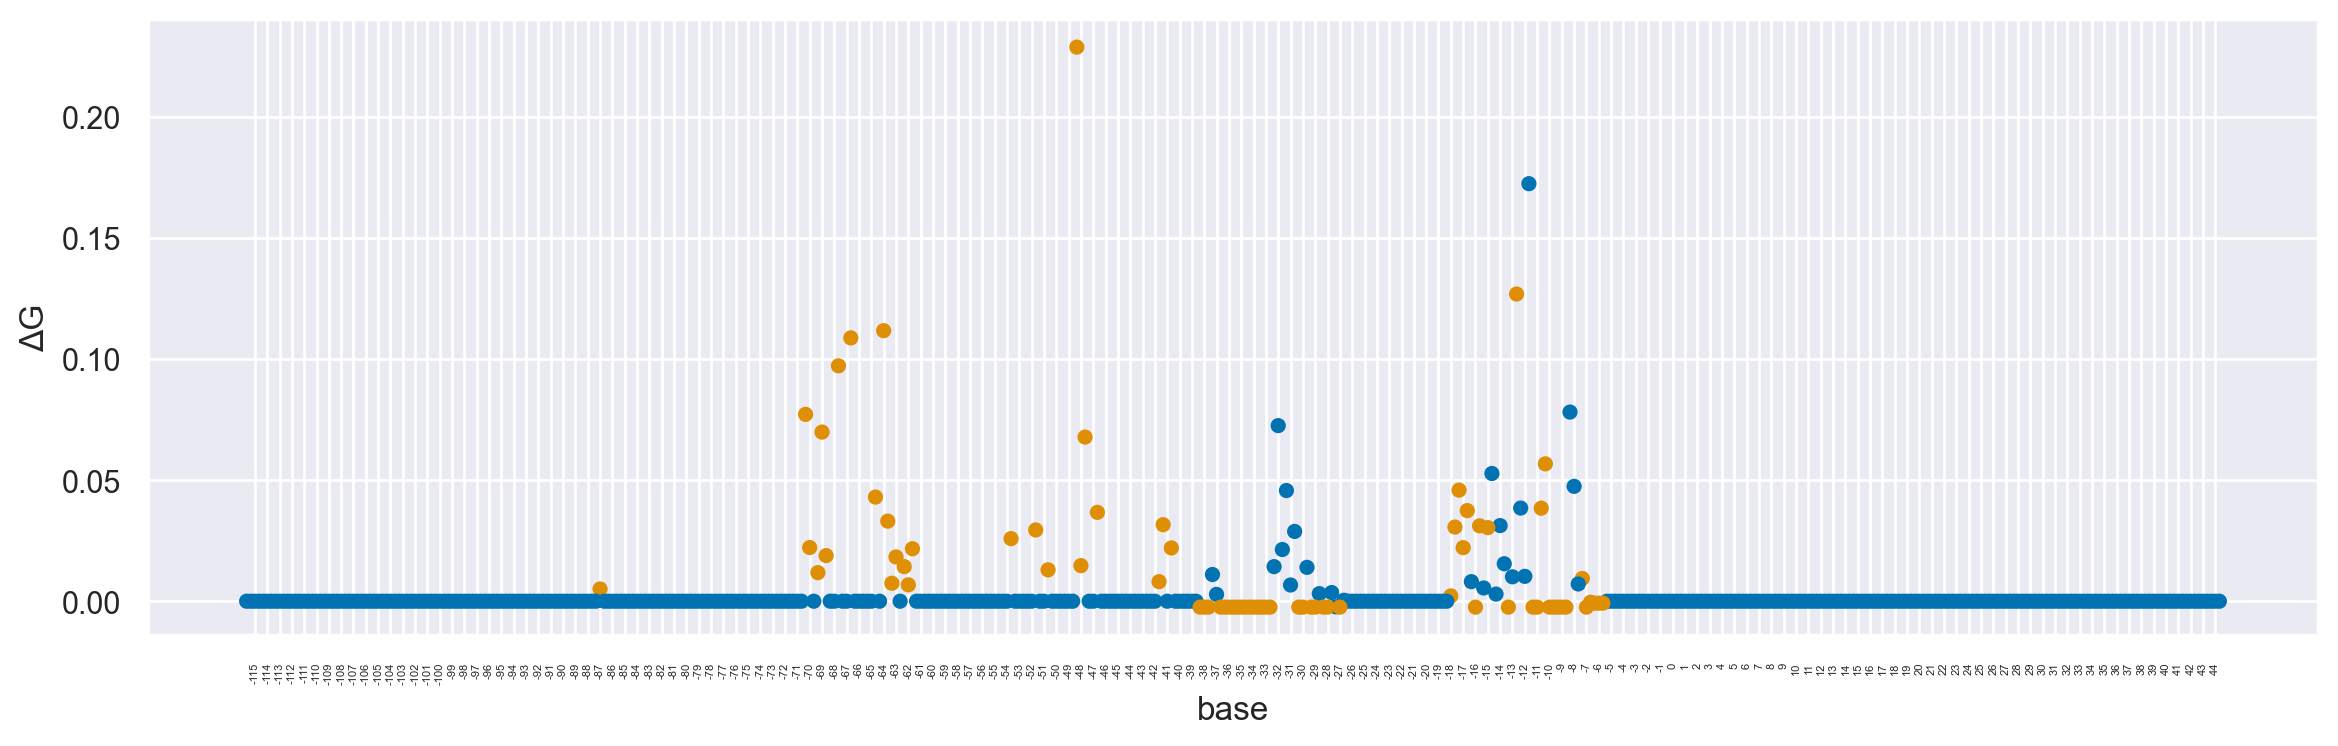

In [61]:
x = eval_lagator_single_mutation('xylAp', 'Glucose')


color_dict = {
    1: sns.color_palette('colorblind')[0],
    0: sns.color_palette('colorblind')[1]
}

fig, ax = plt.subplots(figsize=(14, 4))
ax.scatter(x['index'], x['brick'], color=[color_dict[y] for y in x['same_TSS']], s=20)#, color=x['same_TSS'])
ax.set_ylabel("ΔG")
ax.set_xlabel("base")
ax.set_xticks(np.arange(2, 480, 3), [str(x - 116) for x in np.arange(1, 161)], fontsize=4, rotation=90);

### xylFp

Top 10 single mutations: 


,index,pos,wt_base,mut_base,brick,same_TSS
0,312,-12.0,A,T,0.175883,1
1,324,-8.0,A,T,0.132975,0
2,250,-32.0,T,A,0.081453,1
3,315,-11.0,A,T,0.069162,0
4,460,38.0,C,A,0.055518,0
5,254,-31.0,T,C,0.050842,1
6,441,31.0,C,T,0.048221,0
7,298,-16.0,T,A,0.047672,1
8,318,-10.0,A,T,0.040050,1
9,310,-12.0,A,C,0.039246,1


Highest observed expression shift: 


promoter                                              xylFp
source                                               genome
expression_shift                                        1.0
growth_condition                                    Glucose
growth_condition_info    M9 Minimal Media with 0.5% Glucose
replicate                                                 1
pos                                                     -25
int_base                                                  4
wt_base                                                   C
base                                                      T
Name: 363, dtype: object

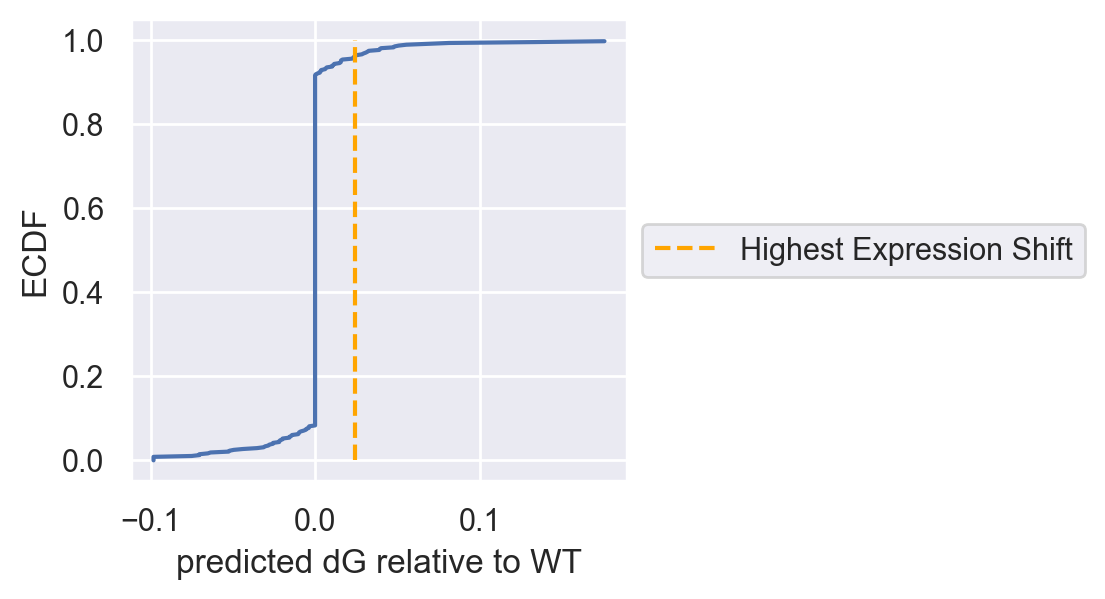

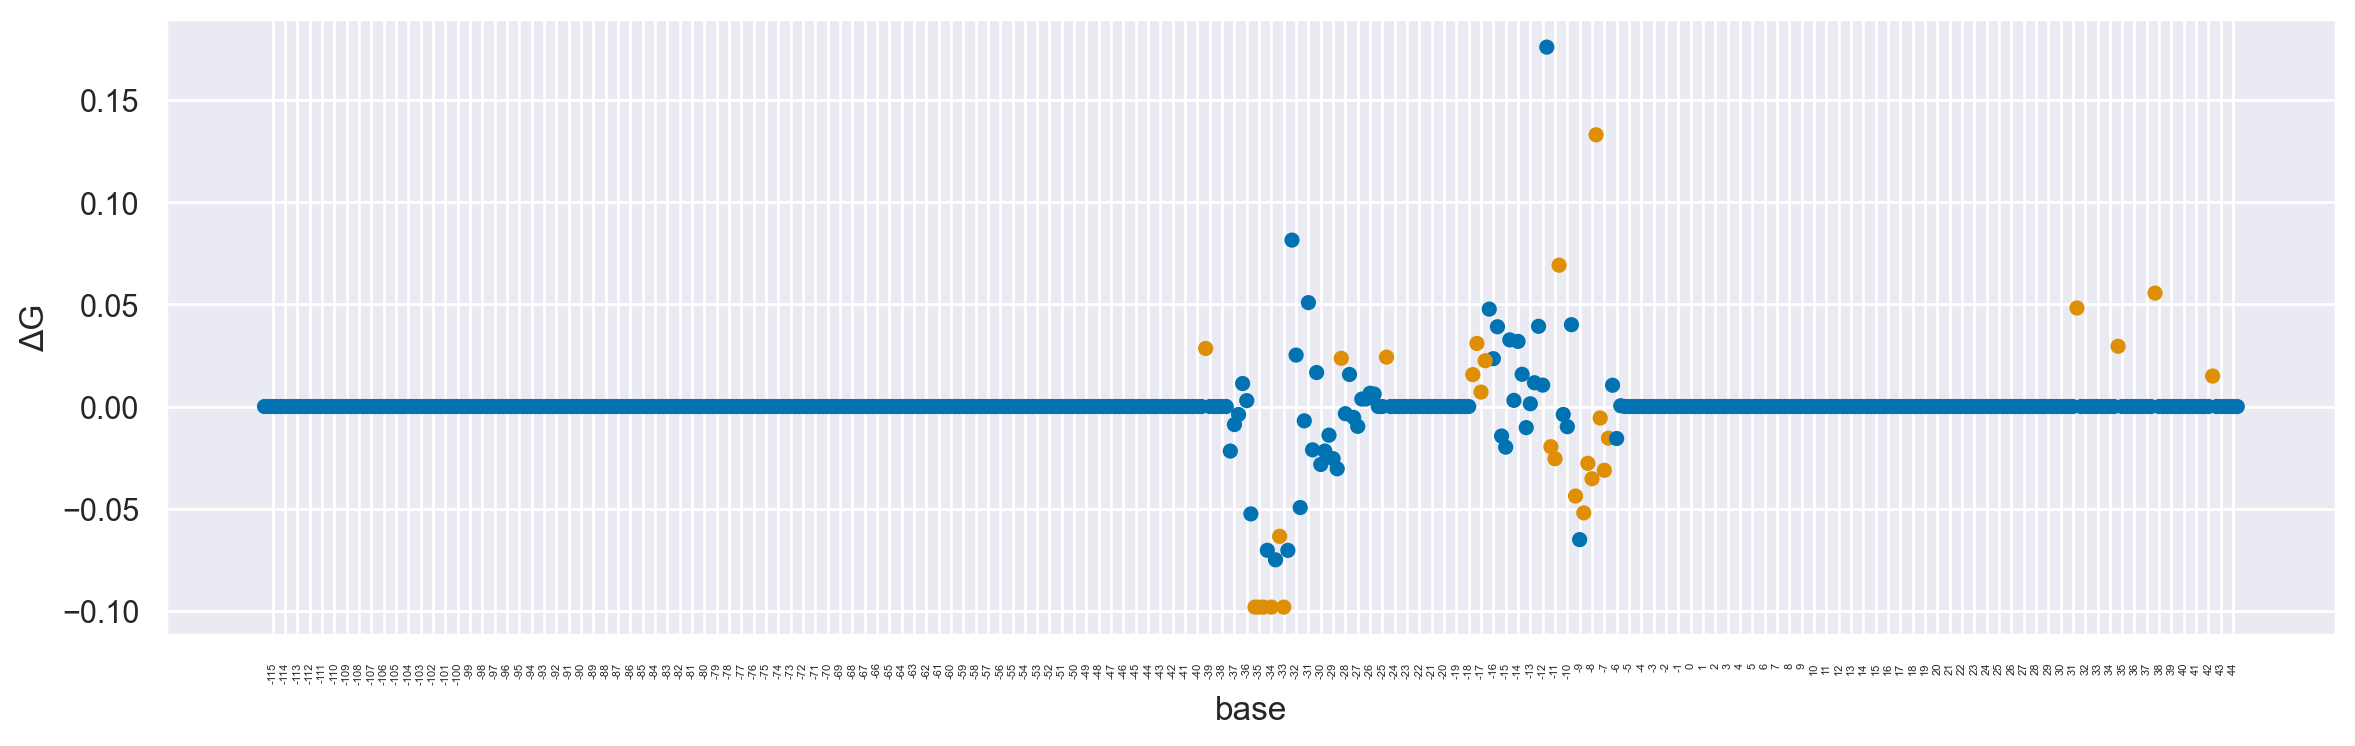

In [62]:
x = eval_lagator_single_mutation('xylFp')


color_dict = {
    1: sns.color_palette('colorblind')[0],
    0: sns.color_palette('colorblind')[1]
}

fig, ax = plt.subplots(figsize=(14, 4))
ax.scatter(x['index'], x['brick'], color=[color_dict[y] for y in x['same_TSS']], s=20)#, color=x['same_TSS'])
ax.set_ylabel("ΔG")
ax.set_xlabel("base")
ax.set_xticks(np.arange(2, 480, 3), [str(x - 116) for x in np.arange(1, 161)], fontsize=4, rotation=90);

#### rspAp

Top 10 single mutations: 


,index,pos,wt_base,mut_base,brick,same_TSS
0,114,-78.0,G,T,0.108020,0
1,247,-33.0,T,A,0.083610,1
2,322,-8.0,T,A,0.081786,1
3,279,-23.0,G,T,0.079740,0
4,250,-32.0,A,C,0.059901,1
5,318,-10.0,G,T,0.051878,1
6,323,-8.0,T,C,0.049673,1
7,298,-16.0,T,A,0.048934,1
8,300,-16.0,T,G,0.040066,1
9,158,-63.0,C,G,0.033618,0


Highest observed expression shift: 


promoter                                              rspAp
source                                               genome
expression_shift                                        1.0
growth_condition                                    Glucose
growth_condition_info    M9 Minimal Media with 0.5% Glucose
replicate                                                 1
pos                                                     -32
int_base                                                  4
wt_base                                                   A
base                                                      T
Name: 335, dtype: object

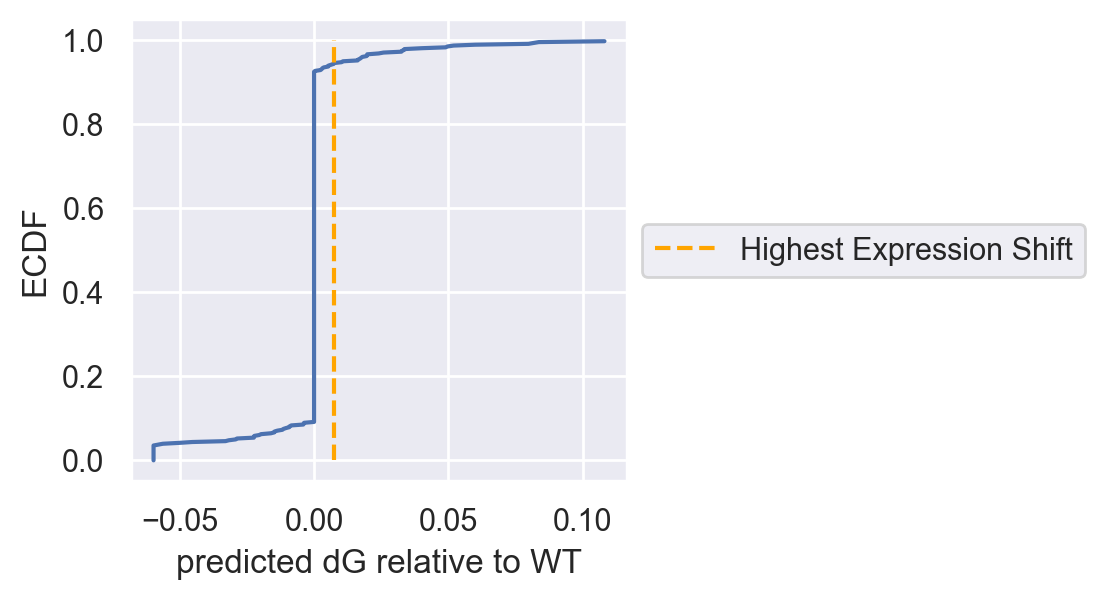

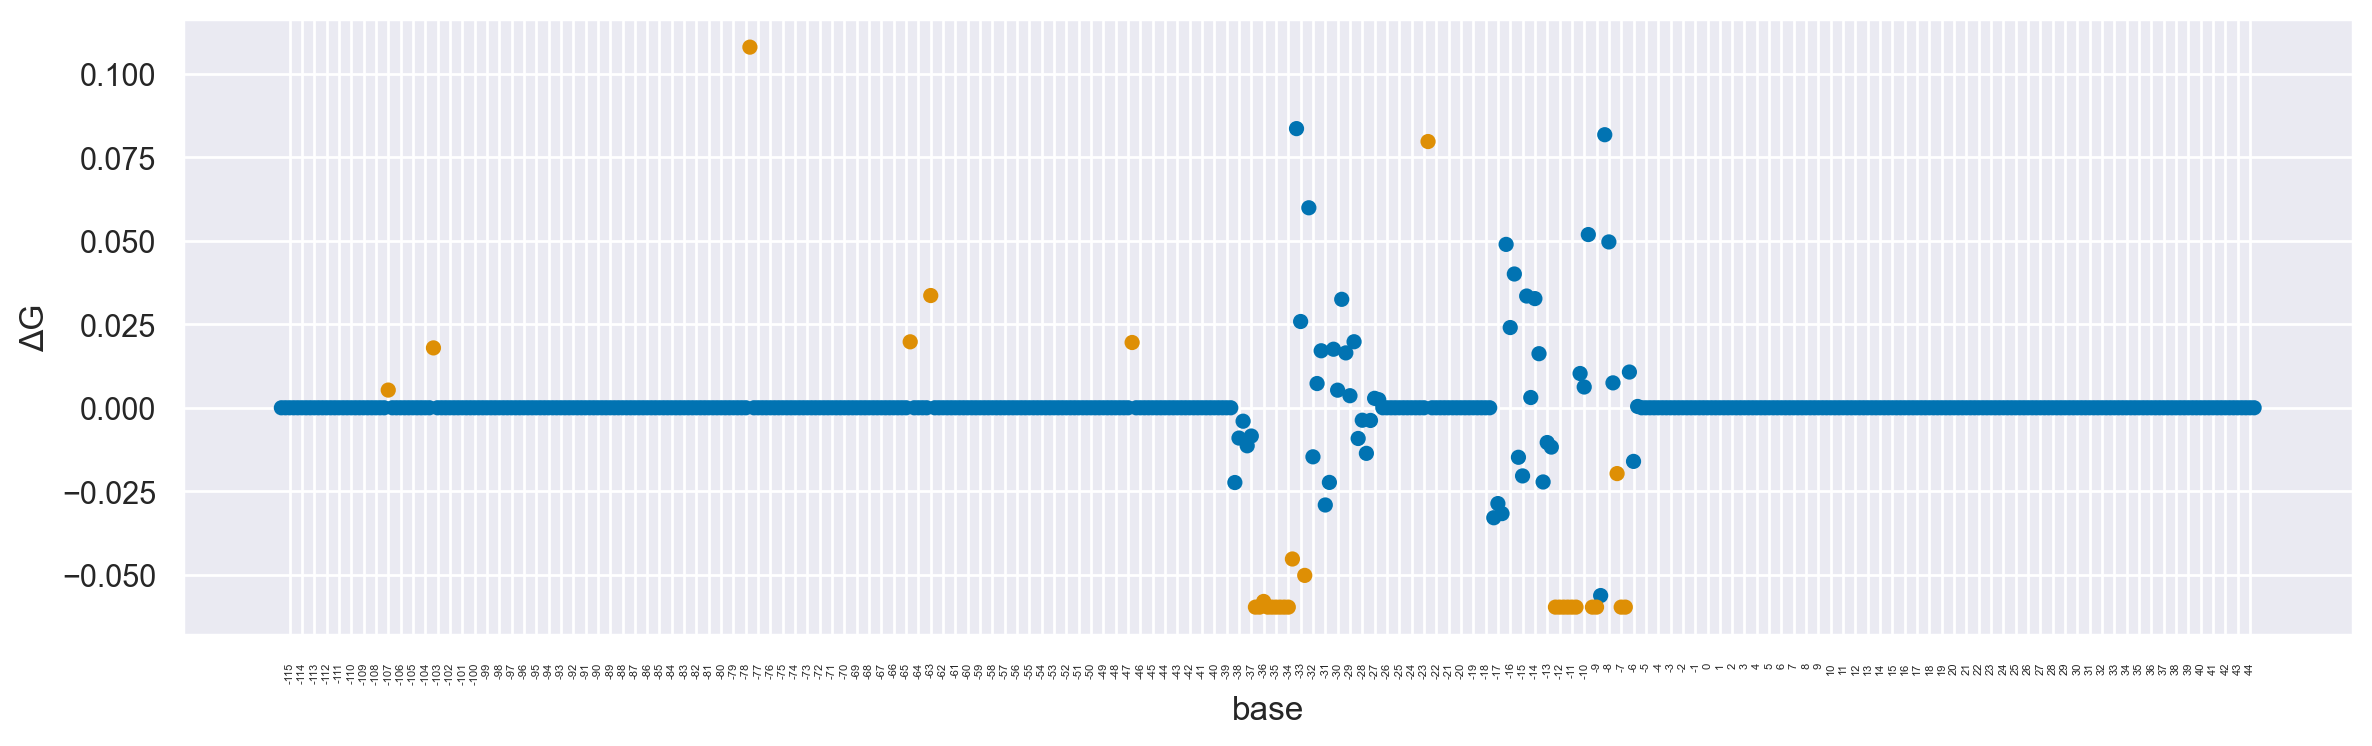

In [63]:
x = eval_lagator_single_mutation('rspAp', 'Glucose')

color_dict = {
    1: sns.color_palette('colorblind')[0],
    0: sns.color_palette('colorblind')[1]
}

fig, ax = plt.subplots(figsize=(14, 4))
ax.scatter(x['index'], x['brick'], color=[color_dict[y] for y in x['same_TSS']], s=20)#, color=x['same_TSS'])
ax.set_ylabel("ΔG")
ax.set_xlabel("base")
ax.set_xticks(np.arange(2, 480, 3), [str(x - 116) for x in np.arange(1, 161)], fontsize=4, rotation=90);

Now test out double mutations

In [28]:
def create_double_mutations(sequence):
    """Create all possible double mutations for a given sequence
    and return them as an arry of integers."""
    
    num_seq_dict = dict(A=0, C=1, G=2, T=3)
    mutant_list = [[num_seq_dict[x] for x in list(sequence)]]
    mutations = [('N', 'N')]
    for i in range(159):
        for j in range(i+1, 160):
            base1 = sequence[i]
            base2 = sequence[j]
            for b in filter(lambda x: x != base1, ['A', 'C', 'G', 'T']):
                new_sequence = list(deepcopy(sequence))
                new_sequence[i] = b
                for bb in filter(lambda x: x != base2, ['A', 'C', 'G', 'T']):
                    new_new_sequence = list(deepcopy(new_sequence))
                    new_new_sequence[j] = bb
                    mutant_list.append([num_seq_dict[x] for x in list(new_new_sequence)])
                    mutations.append(((i, sequence[i], b), (j, sequence[j], bb)))
    return np.array(mutant_list, dtype=np.int8), mutations

In [29]:
seq = df.loc[df.promoter == 'araBp', 'sequence'].values[0]
mut_list, mutations = create_double_mutations(seq)

In [30]:
treatAs = "36N"
bricks = [np.exp((-getBrickDict({treatAs: np.array([x])}, theModel)[treatAs][0])* 0.04)  for x in mut_list]
max_bricks = [np.max(brick) for brick in bricks]
len(max_bricks)

114481

In [31]:
ordered_mutations = np.flip(np.argsort(max_bricks))
for i in range(25):
    ind = ordered_mutations[i]
    print(np.floor((ind - 1)/3), mutations[ind], max_bricks[ind])

27770.0 ((76, 'C', 'T'), (99, 'C', 'A')) 1.075937424131759
13395.0 ((31, 'T', 'A'), (33, 'G', 'A')) 1.0518910983213725
11837.0 ((27, 'C', 'T'), (31, 'T', 'A')) 1.0317128875251043
4696.0 ((10, 'T', 'C'), (31, 'T', 'A')) 1.028199051708909
13398.0 ((31, 'T', 'A'), (34, 'C', 'A')) 1.0028917461632385
11042.0 ((25, 'C', 'T'), (31, 'T', 'A')) 1.0021980898633593
12229.0 ((28, 'A', 'G'), (31, 'T', 'A')) 1.0019721664708412
1968.0 ((4, 'C', 'A'), (31, 'T', 'A')) 0.9944394843770012
11836.0 ((27, 'C', 'G'), (31, 'T', 'A')) 0.9920277724216591
1970.0 ((4, 'C', 'T'), (31, 'T', 'A')) 0.989657281082448
5139.0 ((11, 'T', 'A'), (31, 'T', 'A')) 0.9875761814899636
5582.0 ((12, 'A', 'T'), (31, 'T', 'A')) 0.9847597110957697
1969.0 ((4, 'C', 'G'), (31, 'T', 'A')) 0.9836558800834718
12230.0 ((28, 'A', 'T'), (31, 'T', 'A')) 0.9829538130372046
2430.0 ((5, 'A', 'C'), (31, 'T', 'A')) 0.9811792125089838
13395.0 ((31, 'T', 'A'), (33, 'G', 'T')) 0.981172069550317
12619.0 ((29, 'C', 'G'), (31, 'T', 'A')) 0.980022348606